# **Generalised SIAM URG**

In [1]:
import itertools
from tqdm.autonotebook import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from qutip import *
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
from functools import partial
import warnings
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import numpy.linalg
import os, sys
from scipy.signal import savgol_filter
from os import devnull
import matplotlib.animation as animation

font = {'size'   : 50}
mpl.rc('font', **font)
mpl.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,nicefrac,braket}')
plt.rcParams["figure.figsize"]= 10, 8
mpl.rcParams['lines.linewidth'] = 2
props = dict(boxstyle='round', ec='black', fc='white', alpha=0.5)

def qload(name):
    fileObject = open(name + '.qu', 'rb')  # open the file for reading
    out = pickle.load(fileObject)  # return the object from the file
    return out


deltaD = 0.05
rho = 2/deltaD
nj = rho*deltaD

corr_folder = './corr_data/'
fig_folder = './figs/'
lfl_wf_folder = './wfs_for_entanglement/'

for folder in (corr_folder, fig_folder, lfl_wf_folder):
    if not os.path.exists(folder): os.mkdir(folder)

<ipython-input-1-577d2fef6cc0>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## RG equations and denominators

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{D}{2} - \frac{U}{2} + \frac{K}{4}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}, \quad d_3 = \omega - \frac{D}{2} + \frac{K}{4}
$$

The RG equations for the symmetric spin-charge Anderson-Kondo are 
$$
\Delta U = 4V^2 n_j\left(\frac{1}{d_0} - \frac{1}{d_1}\right) - \frac{n_j}{2}\left(\frac{J^2}{d_2} - \frac{K^2}{d_3}\right),\\
\Delta V = -\frac{3n_j V}{8}\left[J\left(\frac{1}{d_2} + \frac{1}{d_1}\right) + K \left(\frac{1}{d_3} + \frac{1}{d_0}\right)\right],\\
\Delta J = -\frac{n_j J^2}{d_2}, \quad\quad\Delta K = -\frac{n_j K^2}{d_3}
$$

In [2]:
def den(w, D, U, J, K, Ub=0):
    d0 = w - D/2 + Ub/4 - U/2 + K/4
    d1 = w - D/2 + Ub/4 + U/2 + J/4
    d2 = w - D/2 + Ub/4 + J/4
    d3 = w - D/2 + Ub/4 + K/4
    return np.array([d0, d1, d2, d3])

In [3]:
def rg1(w, D, U, V, J, Ub=0):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K, Ub=Ub)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2) if d1 < 0 else 0
    deltaV = -nj*(V/8)*((3*J + 4*Ub)*(1/d1 + 1/d2) + 4*Ub*(1/d0 + 1/d3)) if d1 < 0 else 0
    deltaJ = -nj*(J**2 + 4*J*Ub)/d2 if d2 < 0 else 0

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

def rg2(w, D, U, V, K):
    J = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) + nj*K**2/(2*d3) if d0 < 0 else 0
    deltaV = -3*nj*V*K*(1/d0 + 1/d3)/8 if d0 < 0 else 0
    deltaK = -nj*K**2/d3

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    K = 0 if (K + deltaK) * K <= 0 else K + deltaK

    return U, V, K

def rg3(w, D, U, V, J):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2)
    deltaV = -3*nj*V*J*(1/d1 + 1/d2)/8
    deltaJ = -nj*J**2/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

## RG flow implementation

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [4]:
def complete_RG(w, D0, U0, V0, J0, Ub=0):
    d1 = den(w, D0, U0, J0, 0, Ub=Ub)[1]
    assert d1 < 0
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg1(w, D, U[-1], V[-1], J[-1], Ub=Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0, Ub=Ub)
        if d1 >= 0 and d2 >= 0:
#             print (d1)
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

def complete_RG2(w, D0, U0, V0, K0):
    U = [U0]
    V = [V0]
    K = [K0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, K_j = rg2(w, D, U[-1], V[-1], K[-1])
        U.append(U_j)
        V.append(V_j)
        K.append(K_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], 0, K[-1])
        if d3 >= 0:
            break
    return np.array(E), np.array(U), np.array(V), np.array(K)

def complete_RG3(w, D0, U0, V0, J0):
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg3(w, D, U[-1], V[-1], J[-1])
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0)
        if d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

## RG flows: Positive $U$ regime

In [ ]:
def plot_rgflows_U_pos():
    D0 = 10
    w = -D0/2
    U0 = D0/10
    V0 = D0/100
    J0 = D0/300
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    steps = E/D0
    txt = '\n'.join([r"$U_0/D_0 = {:.3f}$".format(U0/D0), r"$V_0/D_0 = {:.3f}$".format(V0/D0), r"$J_0/D_0 = {:.3f}$".format(J0/D0)])
    plt.plot(steps, U/D0, 'b', lw=4, label=r'$J_0 > V_0$')
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$U/D_0$")
#     plt.yscale("log")
    plt.text(0.7, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("U_irr,U_gt_0,U.pdf", bbox_inches='tight')
    plt.show()
    plt.plot(steps, V/D0, 'b', lw=4)
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$V/D_0$")
    plt.yscale("log")
    plt.text(0.7, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("U_irr,U_gt_0,V.pdf", bbox_inches='tight')
    plt.show()
    plt.plot(steps, J/D0, 'b', lw=4)
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$J/D_0$")
    plt.yscale("log")
    plt.text(0.7, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("U_irr,U_gt_0,J.pdf", bbox_inches='tight')
    plt.show()
    U0 = D0/10
    V0 = D0/500
    J0 = D0/300
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    steps = E/D0
    txt = '\n'.join([r"$U_0/D_0 = {:.3f}$".format(U0/D0), r"$V_0/D_0 = {:.3f}$".format(V0/D0), r"$J_0/D_0 = {:.3f}$".format(J0/D0)])
    plt.plot(steps, U/D0, 'b', lw=4, label=r'$J_0 < V_0$')
    plt.plot([], [], 'red', lw=4, label=r'$J_0 > V_0$')
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$U/D_0$")
    plt.yscale("log")
    plt.text(0.7, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("U_rel,U_gt_0,U.pdf", bbox_inches='tight')
    plt.show()
    plt.plot(steps, V/D0, 'b', lw=4)
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$V/D_0$")
    plt.yscale("log")
    plt.text(0.7, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("U_rel,U_gt_0,V.pdf", bbox_inches='tight')
    plt.show()
    plt.plot(steps, J/D0, 'b', lw=4)
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$J/D_0$")
    plt.yscale("log")
    plt.text(0.7, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("U_rel,U_gt_0,J.pdf", bbox_inches='tight')
    plt.show()
    
plot_rgflows_U_pos()

## Get $c_s, c_c$ that characterise ground state

In [ ]:
def get_cs(w, D0, U0, V0, J0):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    N = E[-1]/deltaD
    v = V[-1]
    j = J[-1]
    u = U[-1]
    gamma = (3*j/8 + u/4)/v
    c1sq = (1 + gamma/sqrt(gamma**2 + 4))/2
    c2sq = (1 - gamma/sqrt(gamma**2 + 4))/2
    return (c1sq, c2sq)

## $c_s$ $c_c$ under increase of $J_0$

In [ ]:
def get_charge_spin_wts_J():
    D0 = 1000
    U0 = 0.01
    V0 = D0/100
    Jrange = V0 * 10**np.linspace(-2, 2, 50)
    c1sq = []
    c2sq = []
    for J0 in tqdm(Jrange):
        w = -D0/2
        c1, c2 = get_cs(w, D0, U0, V0, J0)
        c1sq.append(c1)
        c2sq.append(c2)
    plt.scatter(Jrange/V0, c1sq, color='r', label=r'$c_s^2$')
    plt.scatter(Jrange/V0, c2sq, color='b', label=r'$c_c^2$', marker='^')
    plt.axhline(1, 0, 1, ls='--', color='r', label=r'$1$')
    plt.axhline(0, 0, 1, ls='--', color='b', label=r'$0$')
    plt.legend(fontsize=45, loc=5).get_frame().set_edgecolor('black')
    plt.yticks(np.arange(-0.1, 1.1, 0.2))
    plt.text(0.25, 0.8, r"$\frac{{J_0}}{{V_0}}={:.2f}$".format(J0/V0), bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xscale("log")
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$c_s^2, c_c^2$")
    plt.savefig("coeffs_vs_J.pdf", bbox_inches='tight')
    plt.show()
get_charge_spin_wts_J()

## $c_s$ $c_c$ under increase of $D_0$

In [ ]:
def get_charge_spin_wts_D():
    Drange = 10**np.linspace(-1, 5, 45)
    U0 = 0.001
    V0 = 0.1
    J0 = 0.09
    c1sq = []
    c2sq = []
    for D0 in tqdm(Drange):
        w = -D0/2
        c1, c2 = get_cs(w, D0, U0, V0, J0)
        c1sq.append(c1)
        c2sq.append(c2)
    plt.scatter(Drange, c1sq, color='r')
    plt.scatter(Drange, c2sq, color='b')

    plt.scatter([], [], s=100, color='r', label=r'$c_s^2$')
    plt.scatter([], [], s=100, color='b', label=r'$c_c^2$', marker='^')
    plt.axhline(1, 0, 1, ls='--', color='r', label=r'$1$')
    plt.axhline(0, 0, 1, ls='--', color='b', label=r'$0$')
    plt.legend(fontsize=45, loc=5).get_frame().set_edgecolor('black')
    plt.yticks(np.arange(-0.1, 1.1, 0.2))
    plt.text(0.22, 0.2, r"$\frac{{J_0}}{{V_0}}={:.2f}$".format(J0/V0), bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xscale("log")
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$c_s^2, c_c^2$")
    plt.savefig("coeffs_vs_D.pdf", bbox_inches='tight')
    plt.show()
get_charge_spin_wts_D()

## $\gamma$ as a function of $D_0$

#### Compare states to find ground state

In [ ]:
def get_Es(w, D0, U0, V0, J0, K0):
    if U0 > 0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        K = [0]
    else:
        E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
        J = [0]
    v = V[-1]
    j = J[-1]
    u = U[-1]
    k = K[-1]
    gamma = (3*j/8 + k/8 + u/4)/v
    delta = np.sqrt(u**2 + 16*v**2)/2
    E1 = -u/4 - delta/2
    E2 = v*(gamma - np.sqrt(gamma**2 + 4)) - u/2 - 3*j/4
    E3 = -3*k/4
    return (E1, E2, E3)
    

def plot_gs():
    D0 = 50
    w = -D0/2
    J0 = 0
    U0 = -D0/100
    V0 = D0/15
    K_rang = 10**np.linspace(-2.4, -1, 60)*D0
    cols = ['r', 'b', 'g']
    for K0 in tqdm(K_rang, total=len(K_rang)):
        E1, E2, E3 = get_Es(w, D0, U0, V0, J0, K0)
        col = 'r' if E1 < E3 else 'b'
        plt.scatter(K0/V0, 0, color=col)

    plt.scatter([], [], color='r', label=r"$E_1 < E_3$")
    plt.scatter([], [], color='b', label=r"$E_1 > E_3$")
    plt.legend()
    plt.xscale("log")
    plt.xlabel(r"$K_0/V_0$")
    plt.ylabel(r"$E_1\text{ vs }E_3$")
    plt.yticks([])
    plt.savefig("E1_vs_E3.pdf", bbox_inches='tight')

    
plot_gs()

#### Diagonalise $H$ in order to calculate $\chi$

In [ ]:
def get_ham(U,V,J,K,h1,h2):
    n = create(2)*destroy(2)
    des = destroy(2)
    crt = create(2)
    Sz = 0.5 * (tensor(n, identity(2)) - tensor(identity(2), n))
    Sp = tensor(crt, des)
    Sm = Sp.dag()
    Cz = 0.5 * (tensor(n, identity(2)) + tensor(identity(2), n) - 1)
    Cp = tensor(crt, crt)
    Cm = Cp.dag()
    H_U = (-U/2) * tensor(Sz**2, identity(2), identity(2))
    H_V = V * tensor(crt, identity(2), des, identity(2)) + V * tensor(identity(2), crt, identity(2), des)
    H_V += H_V.dag()
    H_J = J * (tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp))
    H_K = K * (tensor(Cz, Cz) + 0.5*tensor(Cp, Cm) + 0.5*tensor(Cm, Cp))
    H_h1 = h1 * tensor(Sz, identity(2), identity(2))
    H_h2 = h2 * tensor(Cz, identity(2), identity(2))
    return H_U + H_V + H_J + H_K + H_h1 + H_h2

## Calculate $\chi_s, \chi_c$

In [ ]:
def get_Ens(args):
    U,V,J,K,h1,h2 = args
    H = get_ham(U,V,J,K,h1,h2)
    E,_ = H.eigenstates()
    return E

def get_Z(E, deltah, Trange):
    E0, E1, E2 = E
    Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
    ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
    Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
    Zp = (ZplusdeltaZ - Z) / deltah
    Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
    return Z, Zp, Zpp
    

def get_chi_spin(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,deltah,0))/norm
    E2 = get_Ens((U,V,J,K,2*deltah,0))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

def get_chi_charge(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,0,deltah))/norm
    E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

## $U>0$ regime, $\chi_s$

In [ ]:
def chi_pos_U():
    D0 = 50
    w = -D0/2
    U0 = D0/10
    V0 = D0/100
    J0 = V0
    K = 0

    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    U = U[-1]
    V = V[-1]
    J = J[-1]

    Trange = 10**np.linspace(-0.5, 3.5, 70)
    chi = get_chi_spin(U,V,J,K,Trange)
    Trange = Trange[~np.isnan(chi)]
    chi = chi[~np.isnan(chi)]
    plt.scatter(Trange/D0, chi*Trange, color='b')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\chi \times T$")
    plt.axhline(1/8, 0, 1, ls="--", color='black', label=r'$1/8$')
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.72, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chiT.pdf", bbox_inches='tight')
    plt.legend()
    plt.show()
    
    J0 = V0*50

    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    U = U[-1]
    V = V[-1]
    J = J[-1]

    chi = get_chi_spin(U,V,J,K,Trange)
    Trange = Trange[~np.isnan(chi)]
    chi = chi[~np.isnan(chi)]
    plt.scatter(Trange/D0, chi*Trange, color='b')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\chi \times T$")
    plt.axhline(1/8, 0, 1, ls="--", color='black', label=r'$1/8$')
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.72, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chiT_large.pdf", bbox_inches='tight')
    plt.legend()
    plt.show()
    
    plt.scatter(Trange/D0, chi/max(chi), color='b')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\nicefrac{\chi}{\chi(0)}$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.3, 0.25, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chi.pdf", bbox_inches='tight')
    plt.show()
    
chi_pos_U()

## $U>0$ regime, $\chi_c$

In [ ]:
def chi_c():
    D0 = 200
    w = -D0/2
    U0 = D0/10
    V0 = D0/10
    K = 0
    names = ('small', 'large')
    for name, J0 in zip(names, (V0/2, V0*2)):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        U = U[-1]
        V = V[-1]
        J = J[-1]
        Trange = 10**np.linspace(0, 5, 100)
        chi = get_chi_charge(U,V,J,K,Trange)
        Trange = Trange[~np.isnan(chi)]
        chi = chi[~np.isnan(chi)]
        plt.scatter(Trange/D0, chi, color='b')
        plt.xlabel(r"$T/D_0$")
        plt.ylabel(r"$\chi_c$")
        plt.xscale("log")
        txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
        plt.text(0.3, 0.3, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig("chiC_posU_J0={:.0f}.pdf".format(J0), bbox_inches='tight')
        plt.show()
        
chi_c()

## Calculate $\chi$ in $U<0$

In [ ]:
def chic_neg_U():
    D0 = 80
    w = -D0/2
    J = 0
    U0 = -D0/10
    V0 = D0/100
    K0 = D0/10
    E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
    U = U[-1]
    V = V[-1]
    K = K[-1]

    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,0,deltah))/norm
    E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
    Trange = 10**np.linspace(-1, 5, 100)

    Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
    ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
    Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
    Zp = (ZplusdeltaZ - Z) / deltah
    # print (E0)
    Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
    chi = Trange * (Zpp/Z - (Zp/Z)**2)
    Trange = Trange[~np.isnan(chi)]
    chi = chi[~np.isnan(chi)]
    
    plt.scatter(Trange/D0, chi*Trange, color='b')
    plt.axhline(1/8, 0, 1, ls="--", color='b', label=r"$\frac{1}{8}$")
    plt.legend()
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\chi_c \times T$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$K_0/D_0 = {}$".format(K0/D0)])
    plt.text(0.7, 0.23, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chic_T.pdf", bbox_inches='tight')
    plt.show()
    
    plt.scatter(Trange/D0, chi/chi[0], color='b')
    plt.legend()
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\nicefrac{\chi_c}{\chi_c(0)}$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$K_0/D_0 = {}$".format(K0/D0)])
    plt.text(0.3, 0.25, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chic.pdf", bbox_inches='tight')
    
chic_neg_U()

## Specific Heat $C_V$

In [5]:
def get_full_ham(t, lattice_dim, U, V, J, Ubath=0):
    imp_length = 1
    total_dim = 2*(imp_length + lattice_dim)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    Sz_bath = 0.5 * (c_all[2].dag()*c_all[2] - c_all[3].dag()*c_all[3])
    Sp_bath = c_all[2].dag()*c_all[3]
    Sm_bath = Sp_bath.dag()
    
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = -(Ubath*4) * Sz_bath**2 
    H_V = V * (c_all[0].dag() * c_all[2] + c_all[1].dag() * c_all[3])
    H_J = J * (Sz_imp * Sz_bath + 0.5 * Sp_imp * Sm_bath + 0.5 * Sm_imp * Sp_bath)
    H_t = sum([-t * c_all[i].dag() * c_all[i+2] for i in range(2*imp_length, total_dim-2)])
#     for i in range(2*imp_length, total_dim-2):
#         j = i+2
#         H_t += -t * c_all[i].dag() * c_all[i+2]

    return H_U + H_J + H_V + H_V.dag() + H_t + (H_t.dag() if H_t != 0 else 0) + H_Ubath

In [ ]:
def get_Cv(T, Ens):
    deltaT = T/100
    E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    T += deltaT
    E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    C_V_T = (E_avg_T_plus_deltaT - E_avg_T)/deltaT
    return C_V_T

def plot_Cv():
    D0 = 1000
    w = -D0/2
    U0 = D0/10
    J0 = D0/10
    V0 = D0/20
    dim = 4
    E,U,V,J = complete_RG(w, D0, U0, V0, J0)
    U = U[-1]
    V = V[-1]
    J = J[-1]
    t = J/150
    H = get_full_ham(t, dim, U, V, J)
    Ens, _ = H.eigenstates()
    Trange = 10**np.linspace(-2.5, 5, 200)
    Cv = []
    for T in tqdm(Trange):
        Cv.append(get_Cv(T, Ens))
    plt.scatter(Trange/D0, Cv, color='r')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$C_{{imp}}$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.4, 0.75, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("Cv.pdf", bbox_inches='tight')
    plt.show()
    
plot_Cv()

### $T=0$ Spectral function

The spectral function will now be calculated using the spectral representation:
$$
	G_{dd}^\sigma(\omega, T \to 0) = \sum_{n}\left[||\langle{GS}|c_{i\sigma}|{n}\rangle||^2\frac{1}{\omega + E_{GS} - E_n} + ||\langle{n}|c_{i\sigma}|{GS}\rangle||^2\frac{1}{\omega + E_n - E_{GS}}\right]\\
$$
where the sum $n$ is over the exact eigenstates of the Hamiltonian, and $E_\text{GS}, E_n$ are the energies of the ground state $|GS\rangle$ and excited state $|n\rangle$ respectively.

The next cell provides some helper functions to modularize the process, while the cell next to that performs the actual calculation.

In [6]:
def get_ham_K(Ek_0, ed, U, V, J, Ubath=0, ignore=0):
    '''Create Hamiltonian in k-space'''
 
    assert ed == -U/2
    dim = len(Ek_0)
    total_dim = 2 * (dim + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    c0_up = sum([c_all[i] for i in range(2, total_dim-1-ignore, 2)])
    c0_dn = sum([c_all[i+1] for i in range(2, total_dim-1-ignore, 2)])
    S0_z = 0.5 * (c0_up.dag()*c0_up - c0_dn.dag()*c0_dn)
    S0_plus = c0_up.dag() * c0_dn
    S0_minus = S0_plus.dag()
    H_J = J * (Sz_imp * S0_z + 0.5 * (Sp_imp * S0_minus + Sm_imp * S0_plus))
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = -(Ubath*24) * S0_z**2
    H_K = sum([Ek_0[i-1]*(c_all[2*i].dag()*c_all[2*i] + c_all[2*i+1].dag()*c_all[2*i+1]) for i in range(1, dim+1)])
    H_V = V * (c_all[0].dag() * c0_up + c_all[1].dag() * c0_dn)

    return H_U + H_Ubath + H_K + H_V + H_V.dag() + H_J

In [7]:
def get_rho_X(args):
    (En, Xn), Xgs, Egs, Z, J, delta, w_range, exc = args
    total_dim = len(Xgs.dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    sign = 1
    if exc == (0,0):
        Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
        Sp_imp = c_all[0].dag()*c_all[1]
        Sm_imp = Sp_imp.dag()
        O1_up = c_all[0]
        if J != 0: O1_up += Sm_imp * c_all[3] + Sz_imp * c_all[2]
        O2_up = O1_up.dag()
    elif exc == (0,2):
        O1_up = c_all[exc[0]]
        O2_up = sum([c_all[i] for i in range(2, total_dim-1, 2)]).dag()/(total_dim/2-1)
        sign = -1
    elif exc == (2,2):
        O1_up = sum([c_all[i] for i in range(2, total_dim-1, 2)])/(total_dim/2-1)
        O2_up = O1_up.dag()

    C1_sq = np.abs(np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0]))
    C2_sq = np.abs(np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0]))
    eta = 4*delta + 0.5*abs(En - Egs)
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    A = (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
    return A


def get_correction_factor(E, X, J, delta, w_range, w_cut, non_int_ht, exc=(0,0)):  
    X0 = X[np.where(E == min(E))]
    wt = np.zeros(2)
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [J], [delta], [w_range], [exc])
    A = sum(Pool().map(get_rho_X, args))
    A /= np.trapz(A, x=w_range)
    h_minus = np.real(non_int_ht/A[w_range == 0])
    wt_plus = np.trapz(A[abs(w_range) >= w_cut], x=w_range[abs(w_range) >= w_cut])
    wt_minus = np.trapz(A[abs(w_range) < w_cut], x=w_range[abs(w_range) < w_cut])
    h_plus = np.real((1 - h_minus*wt_minus)/wt_plus)
    b = w_cut/5
    gamma_sq = b*w_cut/(h_minus - h_plus)
    c = (sqrt(w_cut**2 + 4*gamma_sq) - w_cut)/2
    a = h_minus - b/c
    h_factor = a + b/(c + abs(w_range))
    return h_factor
    
    
def spec_func_U(params, delta, w_range, non_int_ht, Ubath=0, ht_flag=True, exc=(0,0)):
    Ek_0, U, V, J = params
    ed = -U/2
    H = get_ham_K(Ek_0, ed, U, V, J, Ubath=Ubath)
    E, X = H.eigenstates()
    w_cut = delta*1.5/(1+U/10)
    X0 = X[np.where(E == min(E))]
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [J], [delta], [w_range], [exc])
    A = sum(Pool(1).map(get_rho_X, args))
    A = 0.5*(A + np.flip(A))
    A /= np.trapz(A, x=w_range)
    if V > 0 and ht_flag == True: A *= get_correction_factor(E, X, J, delta, w_range, w_cut, non_int_ht, exc=exc)
    return A

In [ ]:
def plot_SF():
    delta = 10
    rho0 = 0.05
    t = 1
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = np.sqrt(delta/(np.pi * rho0))
    non_int_ht = 1/(2*np.pi*delta)
    w_max = 50
    N_w = 2000
    
    U_range = np.array([0, 3, 5, 10, 25])*delta
    w_max_arr = [10, 18, 22, 30, 60]

    for U, w_max in tqdm(zip(U_range, w_max_arr), total=len(U_range)):
        J = U/3
        plt.figure(figsize=(10, 9))
        w_range = np.linspace(-w_max, w_max, N_w)*delta
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        A = spec_func_U((Ek_0, U, V, J), delta, w_range, non_int_ht)
        plt.plot(w_range/delta, A)
        txt = '\n'.join([r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U}}{{\Delta}}={:.2f}$'.format(U/delta)])
        plt.text(0.22, 0.6, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.xlabel("$\omega/\Delta$")
        plt.ylabel("$A_{dd}(\omega)$")
        plt.savefig("spec_func_Ub=0_U_by_delta={:.2f}.pdf".format(U/delta), bbox_inches='tight')
        plt.show()
    
plot_SF()

## Reverse RG

$$
\newcommand{\ket}[1]{\vert{#1}\rangle}\\
\newcommand{\bra}[1]{\langle{#1}\vert}\\
\ket{\Psi}_0 = \left(\otimes_{i=1}^{n_2}\ket{\hat n_{q_i,+,\uparrow}=1}\ket{\hat n_{q_i,+,\downarrow}=1}\right)\ket{\Phi}_\text{cloud} \left(\otimes_{i=1}^{n_2} \ket{\hat n_{q_i,-,\uparrow}=0} \ket{\hat n_{q_i,-,\downarrow}=0}\right)
\\
\ket{\Psi}_1 = U^\dagger_{q \uparrow}U^\dagger_{q \downarrow}\ket{\Psi}_0\\
U^\dagger_{q\beta} = \frac{1}{\sqrt 2}\left[1 + \eta_{1\beta}\right]\\
\eta_{0\beta}^\dagger = V \left[\frac{1}{d_0}\left( 1 - \hat n_{d\overline\beta} \right) + \frac{1}{d_1}\hat n_{d\overline\beta}  \right]c^\dagger_{q\beta}c_{d\beta} + \frac{1}{d_2}\frac{J}{2}\sum_{k} \left( S_d^z \beta c^\dagger_{q\beta}c_{k\beta} + c^\dagger_{d\overline\beta}c_{d\beta}c^\dagger_{q\beta}c_{k\overline\beta}\right) \\
\eta_{1\beta} = V \left[\frac{1}{d_1}\left( 1 - \hat n_{d\overline\beta} \right) + \frac{1}{d_0}\hat n_{d\overline\beta}  \right]c^\dagger_{d\beta}c_{q\beta} + \frac{1}{d_2}\frac{J}{2}\sum_{k} \left( S_d^z \beta c^\dagger_{k\beta}c_{q\beta} + c^\dagger_{d\beta}c_{d\overline\beta}c^\dagger_{k\overline\beta}c_{q\beta}\right)\\
d_0 = \omega - \frac{D}{2} - \frac{U}{2}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}
$$

In [ ]:
def get_overlaps(args):
    small_conf, n2, big_vac, small_vac, X_small = args
    big_conf = [1]*2*n2 + small_conf + [0]*2*n2
    big_state = get_opt(big_conf) * big_vac
    small_state = get_opt(small_conf) * small_vac
    overlap = (small_state.dag() * X_small)[0][0][0]
    return overlap * big_state


def get_wf(params, n1, n2):
    total_dim = 2 * (2*n1 + 2*n2 + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    big_vac = tensor([basis(2,0)]*total_dim)
    small_vac = tensor([basis(2,0)]*(4*n1 + 2))
    small_confs = get_all_combs(4*n1 + 2)
    w, D, u, v, j = params
    Ek = np.linspace(-abs(D), abs(D), 2*n1)
    H_small = get_ham_K(Ek, -u/2, u, v, j)
    _, X_small = H_small.groundstate()
    args = product(small_confs, [n2], [big_vac], [small_vac], [X_small])
    X = sum(list(tqdm(Pool(40).imap(get_overlaps, args), total=len(small_confs))))
    return X


def get_filename(bares, n1_start, N, step):
    return "./rev_rg_wfs/wf-params={},n1_start={},N={},step={}".format(bares, n1_start, N, step)


def get_Udag(params, beta, n1, n2):
    assert beta == 1 or beta == -1
    
    w, D, U, V, J = params
    
    d0 = w - D/2 - U/2
    d1 = w - D/2 + U/2 + J/4
    d2 = w - D/2 + J/4
    
    total_dim = 2 * (2*n1 + 2*n2 + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    c_dbeta = c_all[2*(n2 + n1)] if beta == 1 else c_all[2*(n2 + n1) + 1]
    c_dbeta_bar = c_all[2*(n2 + n1)] if beta == -1 else c_all[2*(n2 + n1) + 1]
    n_dbeta = c_dbeta.dag()*c_dbeta
    n_dbeta_bar = c_dbeta_bar.dag()*c_dbeta_bar
    c_qbeta = c_all[2*(n2-1)] if beta == 1 else c_all[2*(n2-1) + 1]
    c_qbeta_dag = c_all[-2*n2].dag() if beta == 1 else c_all[-2*n2 + 1].dag()
    Sdz = 0.5 * beta * (n_dbeta - n_dbeta_bar)
    sum_k_ckbeta = sum([c_all[i if beta == 1 else i + 1] for i in range(2*n2, 2*(n2+2*n1+1), 2) if i not in (2*(n2 + n1), 2*(n2 + n1)+1)])
    sum_k_ckbeta_bar = sum([c_all[i if beta == -1 else i + 1] for i in range(2*n2, 2*(n2+2*n1+1), 2) if i not in (2*(n2 + n1), 2*(n2 + n1)+1)])
    eta_1beta = V * ((1 - n_dbeta_bar)/d1 + n_dbeta_bar/d0)*c_dbeta.dag()*c_qbeta
    eta_1beta += J * (beta*Sdz*sum_k_ckbeta.dag() + c_dbeta.dag()*c_dbeta_bar*sum_k_ckbeta_bar.dag())*c_qbeta/(2*d2)
    eta_0beta_dag = V * ((1 - n_dbeta_bar)/d0 + n_dbeta_bar/d1)*c_qbeta_dag*c_dbeta
    eta_0beta_dag += J * c_qbeta_dag*(beta*Sdz*sum_k_ckbeta + c_dbeta_bar.dag()*c_dbeta*sum_k_ckbeta_bar)/(2*d2)
    Udag = (1 + eta_1beta + eta_0beta_dag)/sqrt(2)
    return Udag


def generate_wf(params, n1, N, psi, step, paths, n1_start):
    if n1 > N:
        return paths
    n2 = N - n1
    w, D, U, V, J = params
    paths.append(get_filename((w, D[0], U[0], V[0], J[0]), n1_start, N, step))
    if not os.path.exists(paths[-1] + ".qu"):
        params_next = (w, D[step-1], U[step-1], V[step-1], J[step-1])
        Udag_up = get_Udag(params_next, 1, n1, N-n1)
        Udag_dn = get_Udag(params_next, -1, n1, N-n1)
        Udag = 0.5*(Udag_up*Udag_dn + Udag_dn*Udag_up)
        psi = Udag*psi
        qsave(psi, paths[-1])
    else:
        psi = qload(paths[-1])
    
    return generate_wf(params, n1+1, N, psi, step-1, paths, n1_start)



def get_opt(conf):
    total_dim = len(conf)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    opt = 1
    for i,c in enumerate(conf):
        if c == 1: opt = opt * c_all[i].dag()
    return opt


def get_all_combs(n, count=0, confs=[[]]):
    if n == count:
        return confs
    confs = [conf + [c] for conf in confs for c in [0,1]]
    return get_all_combs(n, count=count+1, confs=confs)


def attach_rem(rem_comb, conf, rem):
    total_dim = len(conf) + len(rem)
    count = 0
    for i in sorted(rem):
        conf = np.insert(conf, i, rem_comb[count])
        count += 1
    assert len(conf) == total_dim
    return conf

    
def get_overlap(psi, conf1, conf2):
    assert len(conf1) == len(conf2)
    total_dim = len(conf1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    vac = tensor([basis(2,0)]*total_dim)
    state1 = get_opt(conf1) * vac
    state2 = get_opt(conf2) * vac
    return (state1.dag() * psi)[0][0][0] * (psi.dag() * state2)[0][0][0]


def pool_func(args):
    (rem_comb1,rem_comb2), conf, rem, psi = args
    rem_vac = tensor([basis(2,0)]*len(rem))
    conf1 = attach_rem(rem_comb1, np.copy(conf), rem)
    conf2 = attach_rem(rem_comb2, np.copy(conf), rem)
    f = get_overlap(psi, conf1, conf2)
    return f * (get_opt(rem_comb1) * rem_vac) * (get_opt(rem_comb2) * rem_vac).dag()

def get_ptrace(psi, rem, n1, n2):
    rem_vac = tensor([basis(2,0)]*len(rem))
    total_dim = 4*(n1+n2) + 2
    confs = [[1]*2*n2 + comb + [0]*2*n2 for comb in get_all_combs(total_dim - len(rem) - 4*n2)]
    rem_combs = get_all_combs(len(rem))
    all_confs = product(product(rem_combs, repeat=2), confs, [rem], [psi])
    psi_traced = sum(list(tqdm(Pool(40).imap(pool_func, all_confs), total=2**(total_dim - 4*n2 + len(rem)))))
    return psi_traced
    

def get_MI(psi, rem1, rem2, n1, n2):
    rem = rem1 + rem2
    rho_AB = get_ptrace(psi, rem, n1, n2).unit()
    rem1 = [rem.index(r) for r in rem1]
    rem2 = [rem.index(r) for r in rem2]
    rho_A = rho_AB.ptrace(rem1).unit()
    rho_B = rho_AB.ptrace(rem2).unit()
    S = entropy_vn(rho_A) + entropy_vn(rho_B) - entropy_vn(rho_AB)
    return S


def get_corr(psi, rem):
    total_dim = len(psi.dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    opt = 1
    for i,pos in enumerate(rem):
        opt = opt * c_all[pos].dag() if i % 2 == 0 else c_all[pos]
    corr = np.real(psi.dag() * opt * psi)[0][0]
    return corr

In [ ]:
def rev_RG():
    N = 4
    n1_start = 1
    D0 = 20
    w = -D0/2
    U0 = 1
    V0 = J0 = 0.02
    step = -1
    D,U,V,J = complete_RG(w, D0, U0, V0, J0)
    bares = (w, D[0], U[0], V[0], J[0])
    fname = get_filename(bares, n1_start, N, step)
    psi = get_wf((w, D[-1], U[-1], V[-1], J[-1]), n1_start, N - n1_start) if not os.path.exists(fname + ".qu") else qload(fname)
    qsave(psi, fname)
    paths = generate_wf((w,D,U,V,J), n1_start, N, psi, step-1, [fname], n1_start)


    n1_range = range(2*n1_start, 2*N, 2)
    ylabels = [r"$I(\mathrm{imp:cloud})$",
               r"$I(\mathrm{cloud:cloud})$",
               r"$\langle \hat n_{k_1 \uparrow} \hat n_{k_2 \uparrow} \rangle$",
               r"$\langle \hat n_{k_1 \uparrow} \hat n_{k_2 \downarrow} \rangle$",
               r"$\langle c^\dagger_{k_1 \uparrow} c_{k_1 \downarrow} c^\dagger_{k_2 \downarrow} c_{k_2 \uparrow}\rangle$"]
    fnames = ["mut_I_ie.pdf",
              "mut_I_ee.pdf",
              "corr_same.pdf",
              "corr_opp.pdf",
              "corr_od.pdf"]
    assert len(ylabels) == len(fnames)

    measures = [[] for i in range(len(ylabels))]

    for path, n1 in zip(paths, range(n1_start, N+1)):
        n2 = N - n1
        psi = qload(path)
        fname = get_filename(bares, n1_start, N, n1_start-n1-1) + "-info"
        d_up = 2*n2 + 2*n1
        d_dn = d_up + 1
        k_up = d_up + 2
        k_dn = d_dn + 2
        q_up = d_up - 2
        q_dn = d_dn - 2
        if not os.path.exists(fname + ".npy"):
            I_ie = get_MI(psi, [d_up], [k_dn], n1, n2)
            I_ee = get_MI(psi, [k_dn], [q_dn], n1, n2)
            corr_same = get_corr(psi, (k_up, q_up))
            corr_opp = get_corr(psi, (k_up, q_dn))
            corr_od = get_corr(psi, (k_up, k_dn, q_dn, q_up))
            np.save(fname, [I_ie, I_ee, corr_same, corr_opp, corr_od])
        else:
            I_ie, I_ee, corr_same, corr_opp, corr_od = np.load(fname + ".npy")

        measures[0].append(I_ie)
        measures[1].append(I_ee)
        measures[2].append(corr_same)
        measures[3].append(corr_opp)
        measures[4].append(corr_od)

    for measure, ylabel, fname in zip(measures, ylabels, fnames):
        plt.scatter(list(n1_range), measure, color='b', marker='o')
        plt.xticks(list(n1_range))
        plt.yscale("log")
        plt.xlabel(r"no of $k-$ states in the cloud")
        plt.ylabel(ylabel)
        plt.savefig(fname, bbox_inches='tight')
        plt.show()
        
rev_RG()

# **Tracking degradation of local Fermi liquid**

## Calculation of effective Hamiltonian coefficients

In [8]:
def leh_coeffs(params):
    t, U, V, J, Ub = params
    if V == 0: return 0,0,0
        
    Delta = sqrt(U**2 + 16*V**2)/2
    vgamma = (3*J/4 + U/2)/(2)
    cs_p, cs_m = sqrt(sqrt(vgamma**2 + 4*V**2) - vgamma)/sqrt(2*sqrt(vgamma**2 + 4*V**2)), sqrt(sqrt(vgamma**2 + 4*V**2) + vgamma)/sqrt(2*sqrt(vgamma**2 + 4*V**2))
    cc_p, cc_m = -cs_m, cs_p
    E_gs = -3*J/8 - U/4 - sqrt(vgamma**2 + 4*V**2)
    E_CS = 0
    E_00 = 0
    E_uu = E_ST = -U/2 + J/4
    E_2 = -3*J/8 - U/4 + sqrt(vgamma**2 + 4*V**2)
    E_pm = np.array([-U/4 + Delta/2, -U/4 - Delta/2])
    N_pm = np.array([sqrt(16*V**2 + (U + 2*Delta)**2), sqrt(16*V**2 + (U - 2*Delta)**2)])
    
    delta_pm = E_pm - E_gs
    delta_CS = E_CS - E_gs
    delta_00 = E_00 - E_gs
    delta_uu = E_uu - E_gs
    delta_2 = E_2 - E_gs
    delta_ST = E_ST - E_gs
    a1 = 4*V/(sqrt(2)*N_pm) if 0 not in N_pm else 0
    a2 = np.array([U+2*Delta, U-2*Delta])/(sqrt(2)*N_pm) if 0 not in N_pm else 0
    Sm = cs_m*a1 + cc_m*a2
    Sp = cs_p*a1 + cc_p*a2
    Dm = cs_m*a1 - cc_m*a2
    Dp = cs_p*a1 - cc_p*a2
    
    X1 = sum(Sm**2/delta_pm)
    X2 = sum(Sm**2/delta_pm**2)
    Y1 = sum(Dm**2/delta_pm)
    Y2 = sum(Dm**2/delta_pm**2)
    P = sum(Sp*Sm/delta_pm)
    Q = sum(Dp*Dm/delta_pm)
    F1 = sum(a1*Sm/delta_pm)
    F2 = sum(a2*Sm/delta_pm)
    G1 = sum(a1*Dm/delta_pm)
    G2 = sum(a2*Dm/delta_pm)
    
    coeff_charge = -4*t**4 * (t**(-2)*X1/2 + F2**2 * (1/delta_CS + 2/delta_00) + P**2 / delta_2 - X1 * X2)
    coeff_spin = -t**4 * (t**(-2)*(X1 + Y1) + (F1**2 + G1**2)*(1/delta_ST + 1/delta_uu) + (F2**2 + G2**2)/delta_CS + (P**2 + Q**2)/delta_2 - (X1 + Y1)*(X2 + Y2))
    coeff_spin_second =  8*V*t**2 * cs_m * cc_m * sum(sqrt(2) * a2 / (delta_pm * N_pm))
    max_frac = max((max(t**2/abs(delta_pm)), t**2/abs(delta_CS), t**2/abs(delta_00), t**2/abs(delta_uu), t**2/abs(delta_2), t**2/abs(delta_ST)))
    
    return coeff_charge - coeff_spin - coeff_spin_second, max_frac, np.min((min(delta_pm), delta_CS, delta_00, delta_uu, delta_2, delta_ST))

## Measures of entanglement

In [19]:
def get_MI(Xgs, i, j):
    rho = Xgs * Xgs.dag()
    rho_part = rho.ptrace(i+j)
    I = entropy_mutual(rho_part, list(range(len(i))), list(range(len(i), len(i)+len(j))))
    return I


def get_EE(Xgs, i):
    rho = Xgs * Xgs.dag()
    rho_part = rho.ptrace(i)
    EE = entropy_vn(rho_part)
    return EE


def get_corr(Xgs, i, j):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz = [0.5 * (c_all[2*k].dag()*c_all[2*k] - c_all[2*k+1].dag()*c_all[2*k+1]) for k in (i,j)]
    Sp = [c_all[2*k].dag()*c_all[2*k+1] for k in (i,j)]
    Sm = [Sp_k.dag() for Sp_k in Sp]
    zz = Sz[0] * Sz[1]
    pm = Sp[0] * Sm[1]
    mp = Sm[0] * Sp[1]
    op = Sz[0] * Sz[1] + 0.5 * Sp[0] * Sm[1] + 0.5 * Sm[0] * Sp[1]
    corr = np.real(np.array(Xgs.dag() * op * Xgs)[0][0])
    return corr


def get_chargecorr(Xgs, i, j):
    dim = int(len(Xgs.dims[0])/2)
    Cz = 0.5*(tensor(create(2) * destroy(2), identity(2)) + tensor(identity(2), create(2) * destroy(2)) - 1)
    Cp = tensor(create(2), create(2))
    Cm = Cp.dag()
    zz = tensor([identity(2)]*2*i + [Cz] + [identity(2)]*2*(j-i-1) + [Cz] + [identity(2)]*2*(dim - j - 1))
    pm = tensor([identity(2)]*2*i + [Cp] + [identity(2)]*2*(j-i-1) + [Cm] + [identity(2)]*2*(dim - j - 1))
    mp = tensor([identity(2)]*2*i + [Cm] + [identity(2)]*2*(j-i-1) + [Cp] + [identity(2)]*2*(dim - j - 1))    
    op = zz + 0.5 * (pm + mp)
    charge_corr = np.real(np.array(Xgs.dag() * op * Xgs)[0][0])
    return charge_corr


def get_csm(params):
    U,V,J = params
    vgamma = (3*J/4 + U/2)/(2)
    cs_m = sqrt(sqrt(vgamma**2 + 4*V**2) + vgamma)/sqrt(2*sqrt(vgamma**2 + 4*V**2))
    cc_m = sqrt(1 - cs_m**2)
    return cs_m, cc_m


def get_1p(Xgs, i, j):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    op = c_all[2].dag()*c_all[4] + c_all[4].dag()*c_all[2]
    corr_1p = np.real((Xgs.dag() * op * Xgs)[0][0][0])
    return corr_1p


def get_ising_corr_01(Xgs):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    op = (c_all[2].dag()*c_all[2] - c_all[3].dag()*c_all[3])*(c_all[5].dag()*c_all[5] - c_all[6].dag()*c_all[6])/4
    ising_corr = np.real(np.array(Xgs.dag() * op * Xgs)[0][0])
    return ising_corr


def get_twosite_EEimp(params):
    csm, ccm = get_csm(params)
    return -(csm**2 * np.log(csm**2/2) + ccm**2 * np.log(ccm**2/2))


def get_tb_MI(t, U, lattice_dim, Ubath=0):
    H = get_full_ham(t, lattice_dim, U, 0, 0, Ubath=Ubath)
    H = np.array(H)
    E, X = eigsh(H, k=1, which='SA')
    Xgs_r = Qobj(X[:, 0], dims=tensor([basis(2,0)]*2*(lattice_dim+1)).dims)
    tb_MI = get_MI(Xgs_r, (2,3), (4,5))
    return tb_MI


def get_diag_corr(Xgs, i, j):
    total_dim = int(len(Xgs.dims[0]))
    c_i = tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 1))
    c_j = tensor([sigmaz()]*(j) + [destroy(2)] + [identity(2)]*(total_dim - j - 1))
    diag_corr = np.real(np.array(Xgs.dag() * c_i.dag()*c_i*c_j.dag()*c_j * Xgs)[0][0])
    return diag_corr


def get_odiag_corr(Xgs, inds):
    total_dim = int(len(Xgs.dims[0]))
    k_i, k_j, k_k, k_l = inds
    c_i = tensor([sigmaz()]*(k_i) + [destroy(2)] + [identity(2)]*(total_dim - k_i - 1))
    c_j = tensor([sigmaz()]*(k_j) + [destroy(2)] + [identity(2)]*(total_dim - k_j - 1))
    c_k = tensor([sigmaz()]*(k_k) + [destroy(2)] + [identity(2)]*(total_dim - k_k - 1))
    c_l = tensor([sigmaz()]*(k_l) + [destroy(2)] + [identity(2)]*(total_dim - k_l - 1))
    odiag_corr = np.real(np.array(Xgs.dag() * c_i.dag()*c_k.dag()*c_j*c_l * Xgs)[0][0])
    return odiag_corr


def get_odlro(Xgs):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    odlro = np.real(np.array(Xgs.dag() * c_all[0].dag()*c_all[1].dag()*c_all[3]*c_all[2] * Xgs)[0][0])
    return odlro


def get_sc_delta(Xgs):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    odlro = np.real(np.array(Xgs.dag() *c_all[3]*c_all[2] * Xgs)[0][0])
    return odlro


def get_I3(Xgs, i, j, k):
    I_ijk = get_MI(Xgs, i, j) + get_MI(Xgs, i, k) - get_MI(Xgs, i, j+k)
    return I_ijk


### Manager and miscellaneous functions

In [17]:
def get_psi(t, lattice_dim, U, V, J, index, load_wf, Ubath=0):
    '''obtains and saves wavefunction given set of parameters
    using ED, or by loads from file if available'''
    
    Ek_0 = 2*t*np.linspace(-1, 1, lattice_dim)
    r_path = lfl_wf_folder + index + '-r-wf'
    k_path = lfl_wf_folder + index + 'Ek={:.4f},{:.4f},{:.0f}'.format(Ek_0[0], Ek_0[1], len(Ek_0)) + '-k-wf'
    try:
        if not load_wf: raise ValueError('Wavefunction data is not supposed to be loaded.')
        Xgs_r = qload(r_path)
        Xgs_k = qload(k_path)
    except:
        if not os.path.exists(lfl_wf_folder): os.mkdir(lfl_wf_folder)
        H_r = get_full_ham(t, lattice_dim, U, V, J, Ubath=Ubath)
        H_k = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=Ubath)
        if lattice_dim < 5:
            E, X = H_r.eigenstates()
            E = np.round(E, 5)
            Xgs_r = [X[i] for i,Ei in enumerate(E) if Ei == min(E)]
            E, X = H_k.eigenstates()
            E = np.round(E, 5)
            Xgs_k = [X[i] for i,Ei in enumerate(E) if Ei == min(E)]
        else:
            H_r = np.array(H_r)
            H_k = np.array(H_k)
            Ngs = 5
            E, X = eigsh(H_r, k=Ngs, which='SA')
            E = np.round(E, 5)
            Xgs_r = [Qobj(X[:, i], dims=tensor([basis(2,0)]*2*(lattice_dim+1)).dims) for i in range(Ngs) if E[i] == min(E)]
            E, X = eigsh(H_k, k=Ngs, which='SA')
            E = np.round(E, 5)
            Xgs_k = [Qobj(X[:, i], dims=tensor([basis(2,0)]*2*(lattice_dim+1)).dims) for i in range(Ngs) if E[i] == min(E)]
        qsave(Xgs_r, r_path)
        qsave(Xgs_k, k_path)
    return Xgs_r, Xgs_k
    

def set_subplot(x_data, y_data, xlabel, ylabel, col, text_str, log_scale_x=True, log_scale_y=True, pre="", save=False):
    '''plots and saves the data passed as arguments'''
    
    y_data = np.array(y_data)
    x_data = np.array(x_data)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel(xlabel, fontsize=50)
    ax.set_ylabel(ylabel, fontsize=50)
    if log_scale_x:
        ax.set_xscale("log")
    if pre == "lfl-":
        ax.set_yscale("log")
        
    ax.scatter(x_data, y_data, color='b', marker='o', s=100)
    ax.text(0.22, 0.2, text_str, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    if save:
        if not os.path.exists(fig_folder): os.mkdir(fig_folder)
        fig.savefig(fig_folder+pre+save+".pdf", bbox_inches='tight')
    return fig_folder+pre+save+".pdf", fig, ax


def create_text(params, vals):
    '''creates the string for the information textbox that
    appears on the plot'''
    
    assert len(params) == len(vals)
    text_str = '\n'.join([r"${} = {}$".format(param, val) for param, val in zip(params, vals)])
    return text_str


def get_info_each_param(params):
    '''for each set of parameters, obtains wavefunctions and calculates
    all measures'''

    (U, V, J, Ubath), t, lattice_dim, load_wf, load_corr = params
    if Ubath == 0:
        index = 't={:.4f},dims={:.0f},U={:.4f},V={:.4f},J={:.4f}'.format(t,lattice_dim,U,V,J)
    else:
        index = 't={:.4f},dims={:.0f},U={:.4f},Ubath=U,V={:.4f},J={:.4f}'.format(t,lattice_dim,U,Ubath,V,J)
    try:
        if not load_corr:  raise ValueError('Correlation data is not supposed to be loaded.')
        measures = np.load(corr_folder + index + "-measures.npy", allow_pickle=True)
    except:
        Xgs_r_all, Xgs_k_all = get_psi(t,lattice_dim, U, V, J, index, load_wf, Ubath=Ubath)
        I_01 = sum([get_MI(Xgs_r,[2,3],[4,5]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        EE_d = sum([get_EE(Xgs_r,[0,1]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        I_di = [sum([get_MI(Xgs_r,[0,1],[2+2*i,2+2*i+1]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all) for i in range(lattice_dim)]
        corr_k = sum([get_MI(Xgs_k, [2,3], [4,5]) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        I_dk = sum([get_MI(Xgs_k,[0,1],[2,3]) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        k_diag_corr = sum([get_diag_corr(Xgs_k, 2, 5) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        k_odiag_corr = sum([get_odiag_corr(Xgs_k, (2, 3, 5, 4)) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        corr_di = [sum([get_corr(Xgs_r,0,i+1) for Xgs_r in Xgs_r_all])/len(Xgs_r_all) for i in range(lattice_dim)]
        chargecorr_di = [sum([get_chargecorr(Xgs_r, 0, i+1) for Xgs_r in Xgs_r_all])/len(Xgs_r_all) for i in range(lattice_dim)]
        real_1p = sum([get_1p(Xgs_r, 2, 4) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_diag_par = sum([get_diag_corr(Xgs_r, 2, 4) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_diag_opp = sum([get_diag_corr(Xgs_r, 2, 5) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_diag_charge = 2*(real_diag_par + real_diag_opp)
        real_ising = sum([get_ising_corr_01(Xgs_r) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_odiag_corr = sum([get_odiag_corr(Xgs_r, (2,3,5,4)) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_corr_vec_01 = sum([get_corr(Xgs_r,1,2) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_corr_vec_02 = sum([get_corr(Xgs_r,1,3) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_corr_vec_03 = sum([get_corr(Xgs_r,1,4) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        trip_d01 = sum([get_I3(Xgs_r,(0,1),(2,3),(4,5)) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        odlro = sum([get_odlro(Xgs_r) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        sc_delta = sum([get_sc_delta(Xgs_r) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        measures = np.array([I_01, EE_d, corr_k, I_di, corr_di, chargecorr_di, I_dk, k_diag_corr, k_odiag_corr,
                            real_1p, real_diag_par, real_diag_opp, real_diag_charge, real_ising, real_odiag_corr,
                            real_corr_vec_01, real_corr_vec_02, real_corr_vec_03, trip_d01, odlro, sc_delta], dtype=object)
        if not os.path.exists(corr_folder): os.mkdir(corr_folder)
        np.save(corr_folder + index + "-measures.npy", measures)
    return measures


def extract_measures(all_measures, params, lattice_dim):
    t, U_, V_, J_, Ubath_ = params
    I_01_arr = [info[0] for info in all_measures]
    EE_d_arr = [info[1] for info in all_measures]
    corr_k_arr = [info[2] for info in all_measures]
    I_di_arr = [[info[3][i] for info in all_measures] for i in range(lattice_dim)]
    box_pts = 11
    box = np.ones(box_pts)/box_pts
    corr_di_arr = [[info[4][i] for info in all_measures] for i in range(lattice_dim)]
    chargecorr_di_arr = [[info[5][i] for info in all_measures] for i in range(lattice_dim)]
    I_dk_arr = [info[6] for info in all_measures]
    k_diag_corr_arr = [info[7] for info in all_measures]
    k_odiag_corr_arr = [info[8] for info in all_measures]
    if True in Ubath_ != 0:
        k_odiag_corr_arr = savgol_filter(k_odiag_corr_arr, 11, 3)
    real_1p_arr = [info[9] for info in all_measures]
    real_diag_par_arr = [info[10] for info in all_measures]
    real_diag_opp_arr = [info[11] for info in all_measures]
    real_diag_charge_arr = [info[12] for info in all_measures]
    real_ising_arr = [info[13] for info in all_measures]
    real_odiag_corr_arr = [info[14] for info in all_measures]
    real_corr_vec_01_arr = [info[15] for info in all_measures]
    real_corr_vec_02_arr = [info[16] for info in all_measures]
    real_corr_vec_03_arr = [info[17] for info in all_measures]
    trip_d01_arr = [info[18] for info in all_measures]
    odlro_arr = [info[19] for info in all_measures]
    sc_delta_arr = [info[20] for info in all_measures]
    params = [[t]+list(param) for param in zip(U_, V_, J_, Ubath_)]
    info_all = list(Pool().imap(leh_coeffs, params))
    net_charge_arr = [info[0] for info in info_all]
    max_frac_arr = [info[1] for info in info_all]
    min_diff_arr = [info[2] for info in info_all]
    results = [I_01_arr, EE_d_arr, corr_k_arr, I_di_arr, corr_di_arr, chargecorr_di_arr,
               net_charge_arr, max_frac_arr, min_diff_arr, I_dk_arr, k_diag_corr_arr,
               k_odiag_corr_arr, real_1p_arr, real_diag_par_arr, real_diag_opp_arr,
               real_diag_charge_arr, real_ising_arr, real_odiag_corr_arr, real_corr_vec_01_arr,
               real_corr_vec_02_arr, real_corr_vec_03_arr, trip_d01_arr, odlro_arr,sc_delta_arr]
    return results


def plot_all(t, U_, V_, J_, lattice_dim, indep_var, xlabel, text_str, log_scale_x=True, log_scale_y=True, save=False, load_wf=True, load_corr=True, Ubath_=[]):
    '''manager function that obtains wavefunctions, calculates all measures,
    and plots all info'''
    
    if len(Ubath_) == 0: Ubath_ = 0*np.copy(U_)
    params = [(part_param, t, lattice_dim, load_wf, load_corr) for part_param in zip(U_, V_, J_, Ubath_)]
    num_cpus = 1 if lattice_dim > 5 else (2 if lattice_dim == 5 else 50)
    all_measures = list(tqdm(Pool(num_cpus).imap(get_info_each_param, params), total=len(params)))
    params = (t, U_, V_, J_, Ubath_)
    results = extract_measures(all_measures, params, lattice_dim)
    I_01_arr, EE_d_arr, corr_k_arr, I_di_arr, corr_di_arr, chargecorr_di_arr, net_charge_arr = results[:7]
    max_frac_arr, min_diff_arr, I_dk_arr, k_diag_corr_arr,  k_odiag_corr_arr, real_1p_arr = results[7: 13]
    real_diag_par_arr, real_diag_opp_arr, real_diag_charge_arr, real_ising_arr, real_odiag_corr_arr = results[13: 18]
    real_corr_vec_01_arr, real_corr_vec_02_arr, real_corr_vec_03_arr, trip_d01_arr, odlro_arr,sc_delta_arr = results[18:]
    
    set_subplot(indep_var, sc_delta_arr, xlabel,
                     r"$\langle c_{0 \downarrow}c_{0 \uparrow}\rangle$", 'r', text_str, log_scale_x=log_scale_x, pre="sc-delta-", save=save)
    
    set_subplot(indep_var, odlro_arr, xlabel,
                     r"ODLRO", 'r', text_str, log_scale_x=log_scale_x, pre="odlro-", save=save)
    
    set_subplot(indep_var, I_dk_arr, xlabel,
                     r"$I(d:k)$", 'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="mi-dk-", save=save)
    savep, fig, ax = set_subplot(indep_var, k_diag_corr_arr, xlabel,
                     r"$\langle \hat n_{k \uparrow} \hat n_{q\downarrow}\rangle$", 'r', text_str, log_scale_x=log_scale_x,
                                 log_scale_y=False, pre="corr-k-diag-", save=save)

    set_subplot(indep_var, k_odiag_corr_arr, xlabel,
                r'$\langle c^\dagger_{k_1 \uparrow} c_{k_2 \downarrow} c^\dagger_{k_3 \downarrow} c_{k_4\uparrow}\rangle$', 
                'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="corr-k-od-", save=save)
    
    corr_di_min = [corr_di_arr[i][0] for i in range(1, lattice_dim)]
    corr_di_max = [corr_di_arr[i][-1] for i in range(lattice_dim)]
    
    set_subplot(indep_var, real_1p_arr, xlabel,
                     r"$\langle c^\dagger_{0\uparrow}c_{1\uparrow} + \mathrm{h.c.}\rangle$", 'r', text_str, 
                log_scale_x=log_scale_x, pre="r1p-", save=save)
    
    set_subplot(indep_var, real_diag_par_arr, xlabel,
                      r"$\langle \hat n_{0\uparrow}\hat n_{1\uparrow}\rangle$", 'g', text_str, 
                log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-par-", save=save)
    set_subplot(indep_var, real_diag_opp_arr, xlabel,
                      r"$\langle \hat n_{0\uparrow}\hat n_{1\downarrow}\rangle$", 'b', text_str, 
                log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-opp-", save=save)
    set_subplot(indep_var, real_diag_charge_arr, xlabel,
                      r"$\langle \hat n_{0}\hat n_{1}\rangle$", 'r', text_str, 
                log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-charge-", save=save)
    set_subplot(indep_var, real_ising_arr, xlabel,
                      r"$\langle S^z_{0} S^z_{1}\rangle$", 'g', text_str, log_scale_x=log_scale_x,
                log_scale_y=log_scale_y, pre="r-ising-", save=save)
    set_subplot(indep_var, real_corr_vec_01_arr, xlabel,
                      r"$\langle \vec{S}_{0} \cdot \vec{S}_{1}\rangle$", 'g', text_str,
                log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-vec-corr-01-", save=save)
    set_subplot(indep_var, real_corr_vec_02_arr, xlabel,
                      r"$\langle \vec{S}_{0} \cdot \vec{S}_{2}\rangle$", 'g', text_str,
                log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-vec-corr-02-", save=save)
    set_subplot(indep_var, real_corr_vec_03_arr, xlabel,
                      r"$\langle \vec{S}_{0} \cdot \vec{S}_{3}\rangle$", 'g', text_str,
                log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-vec-corr-03-", save=save)
    set_subplot(indep_var, real_odiag_corr_arr, xlabel,
                      r"$\langle c^\dagger_{0 \uparrow} c_{0\downarrow} c^\dagger_{1\downarrow}c_{1\uparrow}\rangle$", 'b',
                text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-od-", save=save)
    set_subplot(indep_var, trip_d01_arr, xlabel, r"$I(d,0,1)$", 'b', text_str, log_scale_x=log_scale_x,
                log_scale_y=log_scale_y, pre="I3-d01-", save=save)
    
    set_subplot(indep_var, net_charge_arr, xlabel,
                     r"$\mathcal{F}$", 'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="lfl-", save=save)
    set_subplot(indep_var, min_diff_arr, xlabel,
                      r"$\mathrm{min}(\delta E)$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="gap-", save=save)
    set_subplot(indep_var, max_frac_arr, xlabel,
                      r"$\nicefrac{{t^2}}{{\delta E}}$", 'b', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="par-", save=save)
    
    
    savep, fig, ax = set_subplot(indep_var, I_01_arr, xlabel, r"$I(0:1)$", 'black', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="mi-01-", save=save)
    tb_MI_01 = get_tb_MI(t, U_[-1], lattice_dim, Ubath=Ubath_[-1])
    ax.axhline(tb_MI_01, 0, 1, color='g', ls='--', label='\n'.join([r't-binding', r'value']))
    ax.legend(loc='center left')
    fig.savefig(savep, bbox_inches='tight')
    savep, fig, ax = set_subplot(indep_var, EE_d_arr, xlabel, r"$S(d)$", 'b', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="EE-d-", save=save)
    ax.axhline(get_twosite_EEimp((U_[0], V_[0], J_[0])), 0, 1, color='g', ls='--', label='\n'.join([r'two site', r'value']))
    ax.legend(loc='center left')
    fig.savefig(savep, bbox_inches='tight')
    set_subplot(indep_var, corr_k_arr, xlabel, r"$I(k_1:k_2)$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=False,
                pre="corr-k-", save=save)
    set_subplot(range(1, lattice_dim), corr_di_min, r"$i$", r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{{i}}\rangle, U \ll J$",
                'g', text_str, log_scale_x=False, log_scale_y=False, pre="corr-di-min-", save=save)
    set_subplot(range(lattice_dim), corr_di_max, r"$i$", r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{{i}}\rangle, U \gg J$",
                'g', text_str, log_scale_x=False, log_scale_y=False, pre="corr-di-max-", save=save)
    for i in range(lattice_dim):
        savep1, fig1, ax1 = set_subplot(indep_var, I_di_arr[i], xlabel, r"$I(d:{})$".format(int(i)), 'g', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="mi-d{}-".format(int(i)), save=save)
        savep2, fig2, ax2 = set_subplot(indep_var, corr_di_arr[i], xlabel, r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{}\rangle$".format(i), 'black',
                    text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="corr-d{}-".format(i), save=save)
        if i == 0:
            ax1.axhline(2*get_twosite_EEimp((U_[0], V_[0], J_[0])), 0, 1, color='g', ls='--', label=r'dimer $2S(d)$')
            ax2.axhline((-3/4)*get_csm((U_[0], V_[0], J_[0]))[0]**2, 0, 1, color='g',  ls='--', label=r'dimer $\vec S_d \cdot S_0$')
            ax1.legend(loc='center left')
            ax2.legend(loc='center left')
            fig1.savefig(savep1, bbox_inches='tight')
            fig2.savefig(savep2, bbox_inches='tight')
    
    mark = ['o', '^', 'v', '<', '>']
    colors = ['black', 'red', 'brown', 'orange', 'yellow']
    plt.figure(figsize=(14,10))
    for i in range(1, lattice_dim):
        x = indep_var[int(2*len(indep_var)/5):int(3.5*len(indep_var)/5)]
        y = corr_di_arr[i][int(2*len(indep_var)/5):int(3.5*len(indep_var)/5)]
        plt.scatter(x, y, color=colors[i-1], marker=mark[i-1], label=r'$i={}$'.format(i))
        plt.axvline(x[np.argmax(np.abs(y))], 0, 1, ls='--', color=colors[i-1])
    plt.legend(framealpha=0.1, fontsize=35)
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{{i}}\rangle$")
    plt.text(0.85, 0.8, text_str, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    if save: plt.savefig(fig_folder+"corr-all-"+save+".pdf", bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(14,10))
    for i in range(1, lattice_dim):
        plt.scatter(indep_var, I_di_arr[i], marker=mark[i-1], label=r'$i={}$'.format(i))
    plt.legend(fontsize=30)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(r"$I(d:i)$")
    plt.text(0.15, 0.8, text_str, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    if save: plt.savefig(fig_folder+"I-all-"+save+".pdf", bbox_inches='tight')

### Correlations for Gen SIAM

In [21]:
def gen_siam_corr():
    t = 1
    lattice_dim = 6
    U = 1
    U_ = U * np.ones(40)
    J_ = 10**np.linspace(2, -2, 40)
    V_ = np.copy(J_)*3
    text_str = create_text(('t', 'UJ', 'V'), (t, 1, 'J'))
    plot_all(t, U_[3:], V_[3:], J_[3:], lattice_dim, U/J_[3:], r"$\nicefrac{U}{J}$", text_str, log_scale_y=True,
             save="t={:.3f},U={:.0f},V=3J,N={:.0f},J={:.3f},{:.3f},{:.0f}".format(t, U, lattice_dim, J_[0], J_[-1], len(J_)))

gen_siam_corr()

  0%|          | 0/37 [00:00<?, ?it/s]

KeyboardInterrupt: 

Process ForkPoolWorker-475:
Traceback (most recent call last):
  File "<ipython-input-17-34cd2e31e5af>", line 79, in get_info_each_param
    measures = np.load(corr_folder + index + "-measures.npy", allow_pickle=True)
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 417, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: './corr_data/t=1.0000,dims=6,U=100.0000,V=116.6447,J=38.8816-measures.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))

## Correlations for SIAM

In [ ]:
def siam_corr():
    t = 1
    lattice_dim = 4
    U_ = 10**np.linspace(-2, 2, 100)[5:]
    J_ = 0*np.copy(U_)
    V_ = 1/np.copy(U_)
    text_str = create_text(('t', 'UV', 'J'), (t, 1, 0))
    plot_all(t, U_, V_, J_, lattice_dim, U_/V_, r"$\nicefrac{U}{V}$", text_str, log_scale_y=True,
             save="t={:.3f},V=1_over_U,J=0,N={:.0f},U={:.3f},{:.3f},{:.0f}".format(t, lattice_dim, U_[0], U_[-1], len(U_)))

### Correlations for Kondo

In [ ]:
def kondo_corr():
    t = 1
    lattice_dim = 4
    J_ = 10**np.linspace(-4, 1, 50)
    U_ = 0*np.copy(J_)
    V_ = 0*np.copy(J_)
    text_str = create_text(('t', 'U', 'V'), (t, 0, 0))
    plot_all(t, U_, V_, J_, lattice_dim, J_, r"$\nicefrac{U}{J}$", text_str, log_scale_y=True,
             save="t={:.3f},U=0,V=0,N={:.0f},J={:.3f},{:.3f},{:.0f}".format(t, lattice_dim, J_[0], J_[-1], len(J_)))

## Correlations for Gen. SIAM with $U_\text{bath}$

  0%|          | 0/60 [00:00<?, ?it/s]

<ipython-input-17-34cd2e31e5af>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


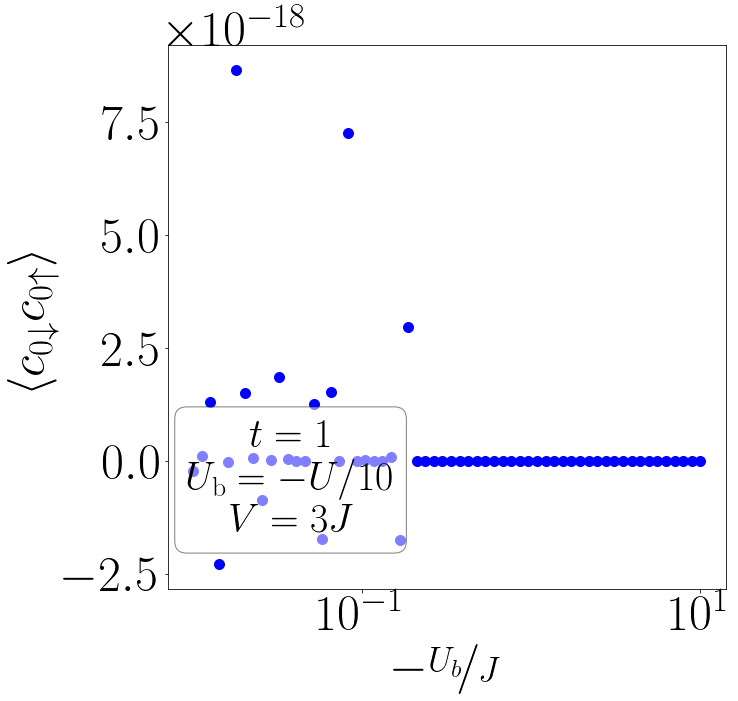

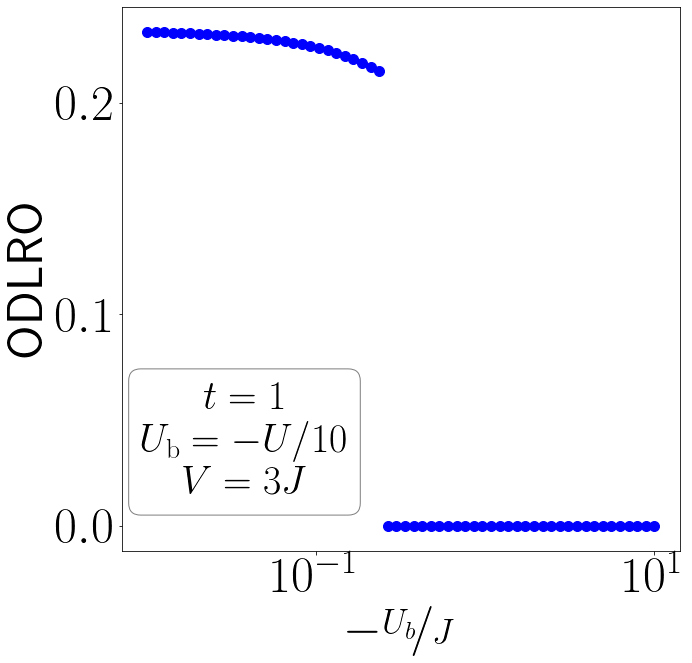

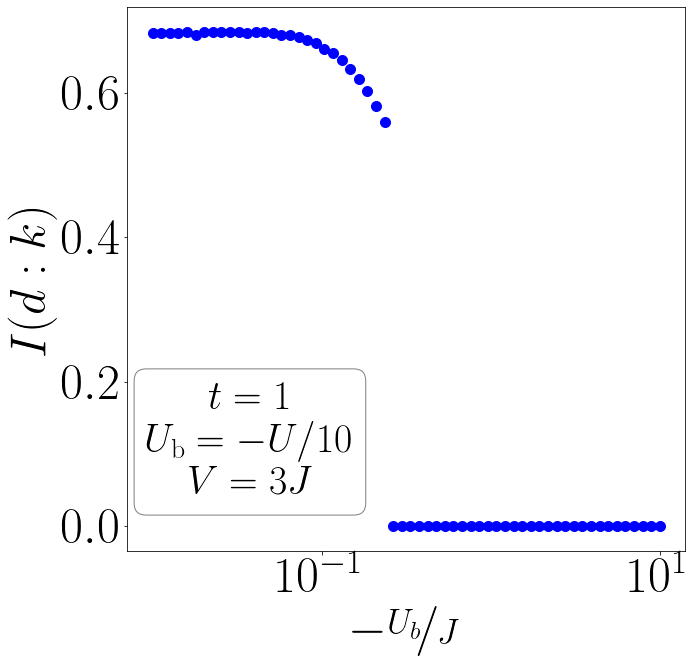

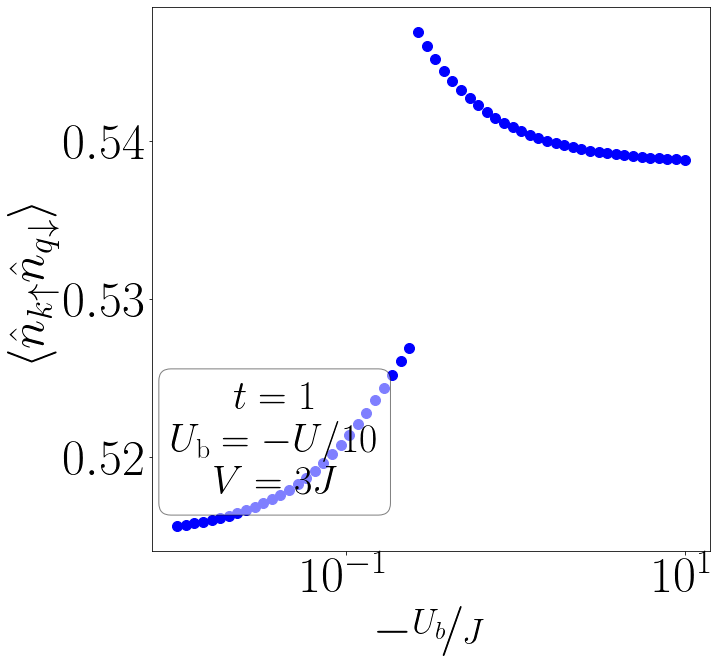

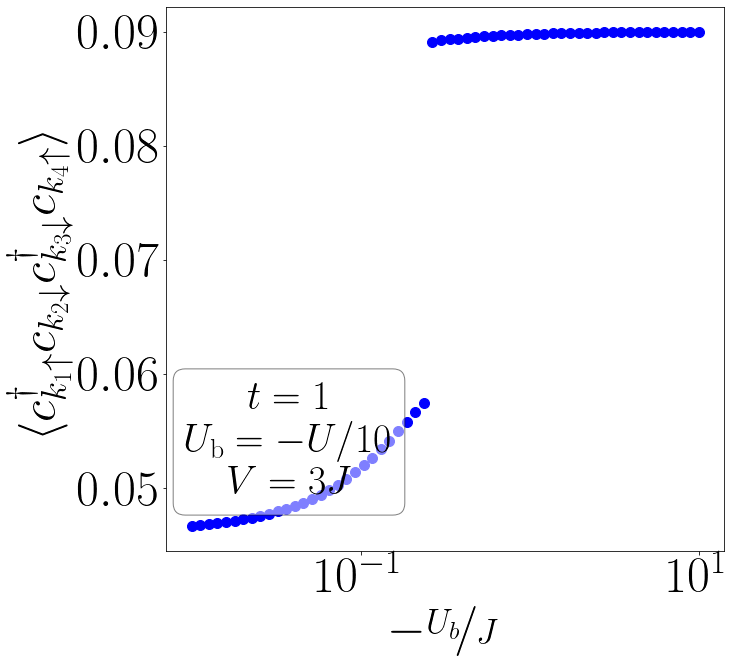

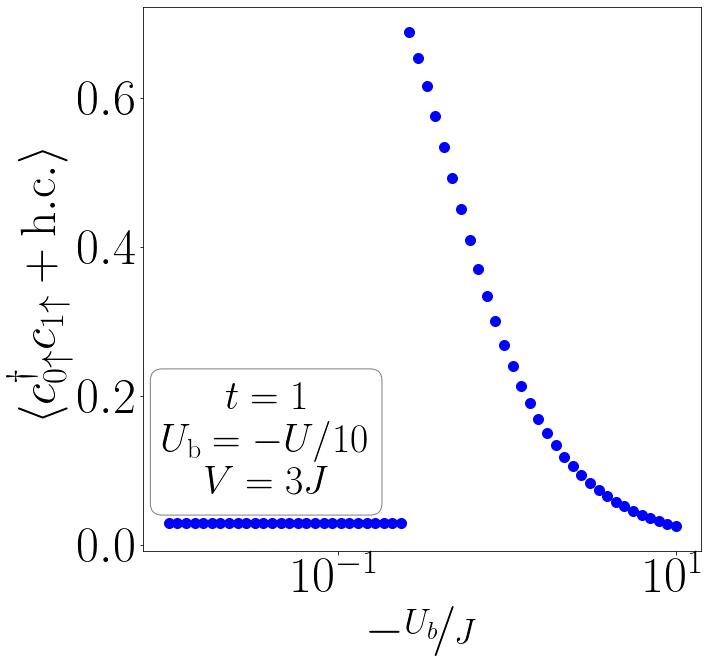

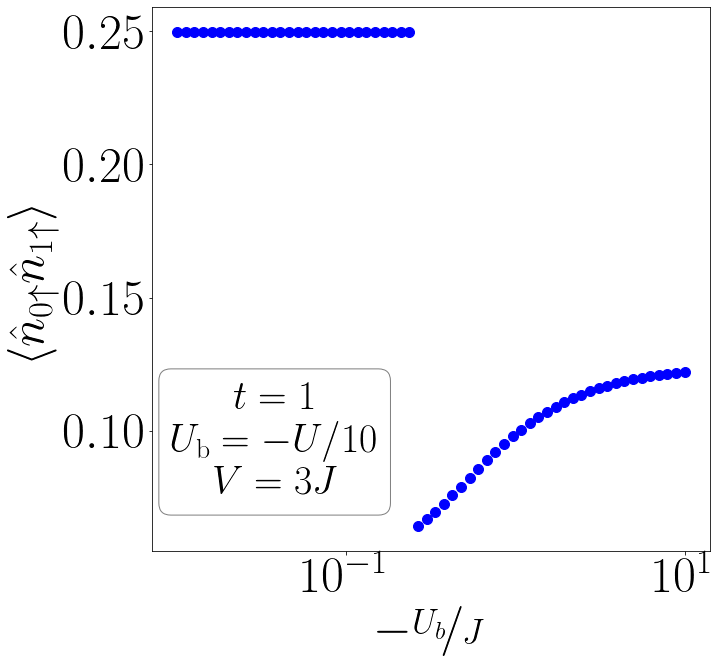

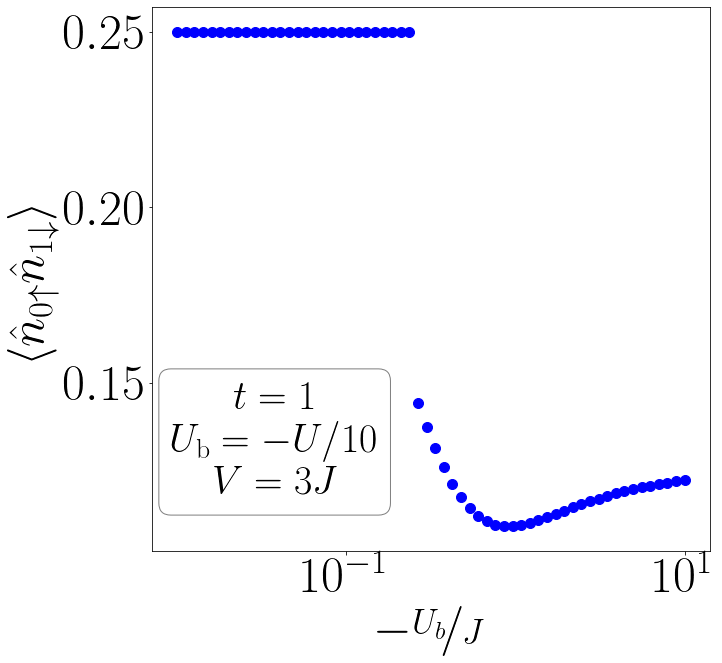

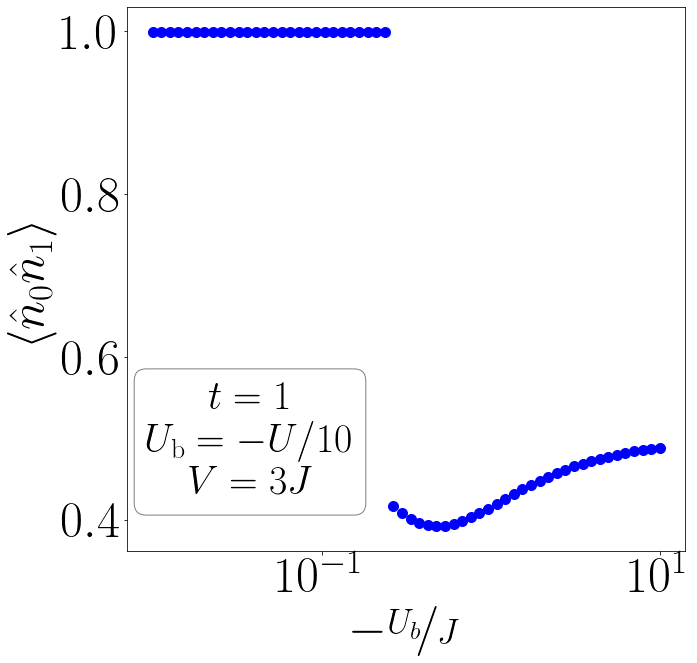

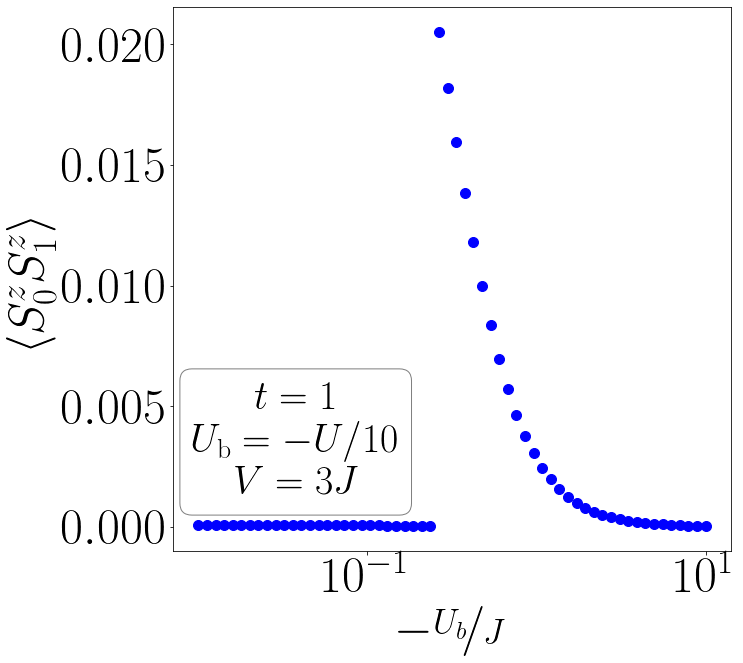

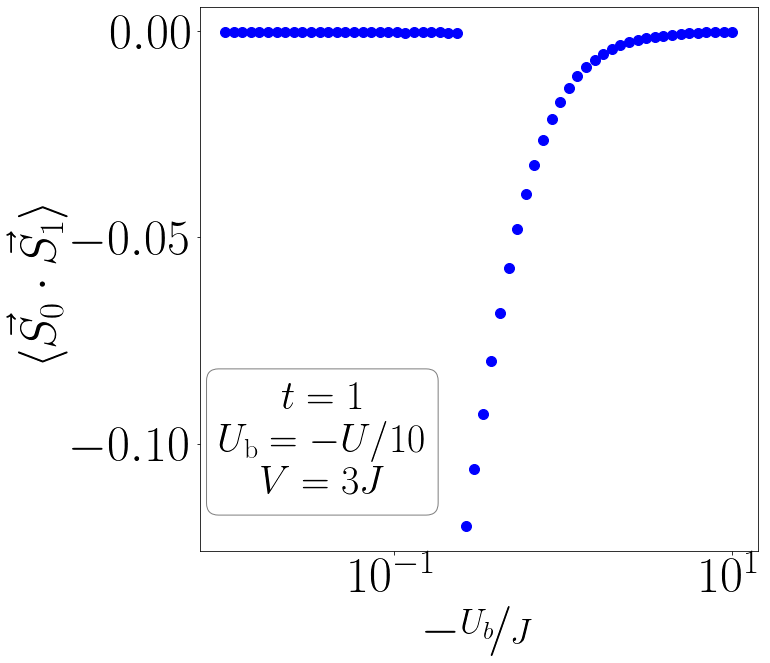

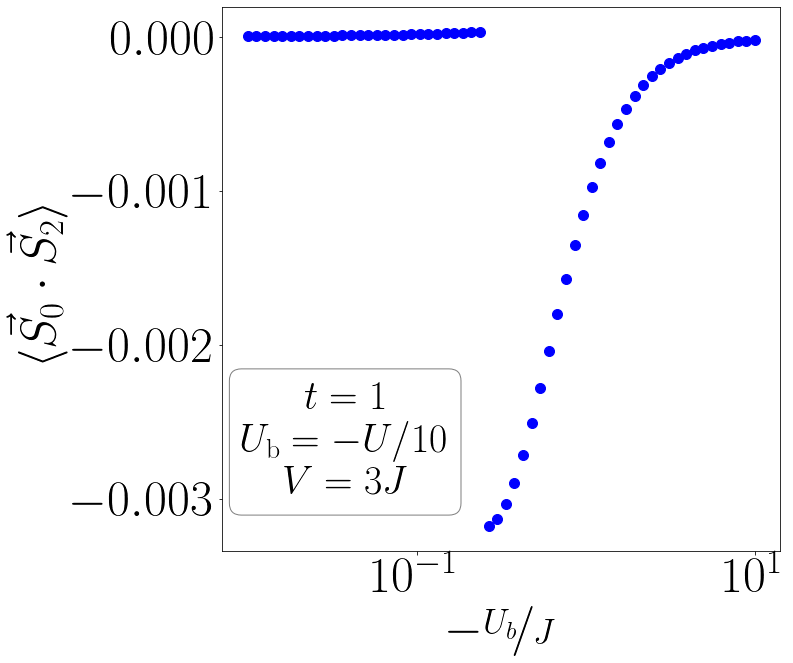

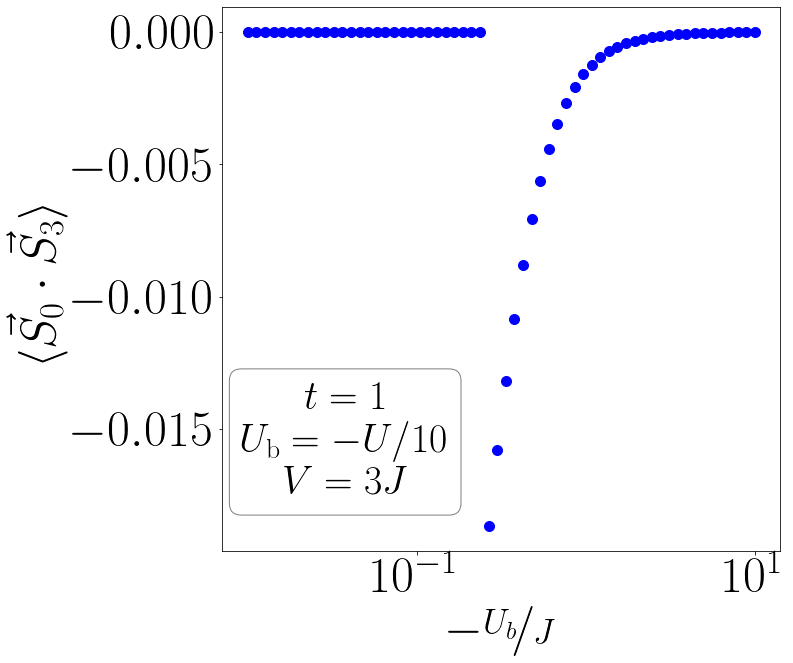

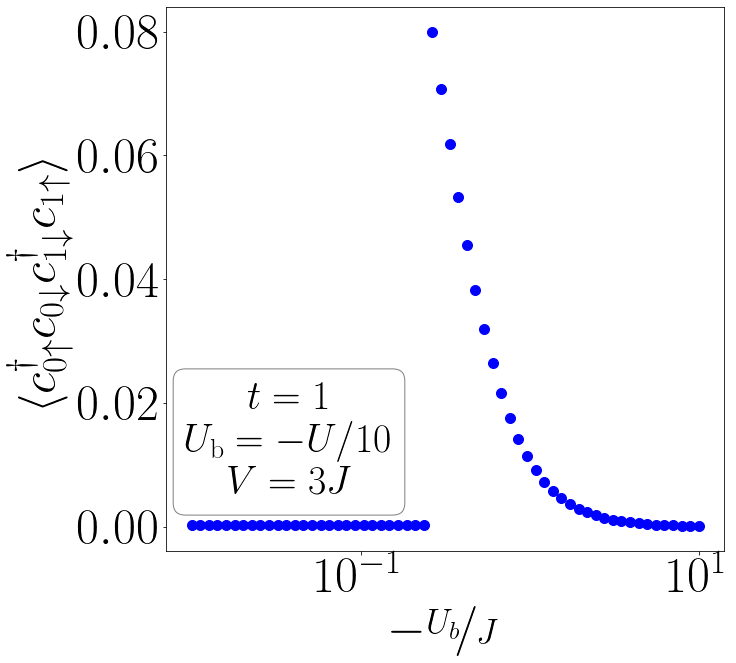

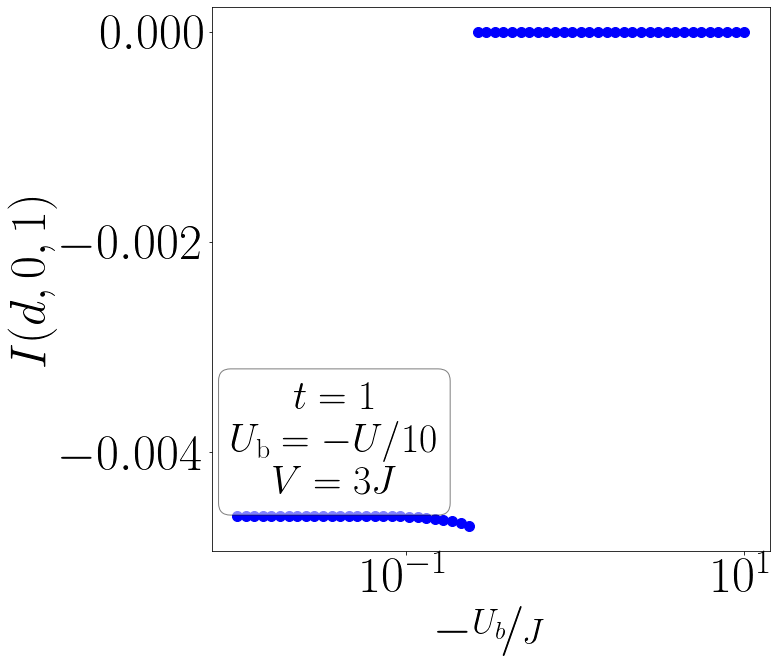

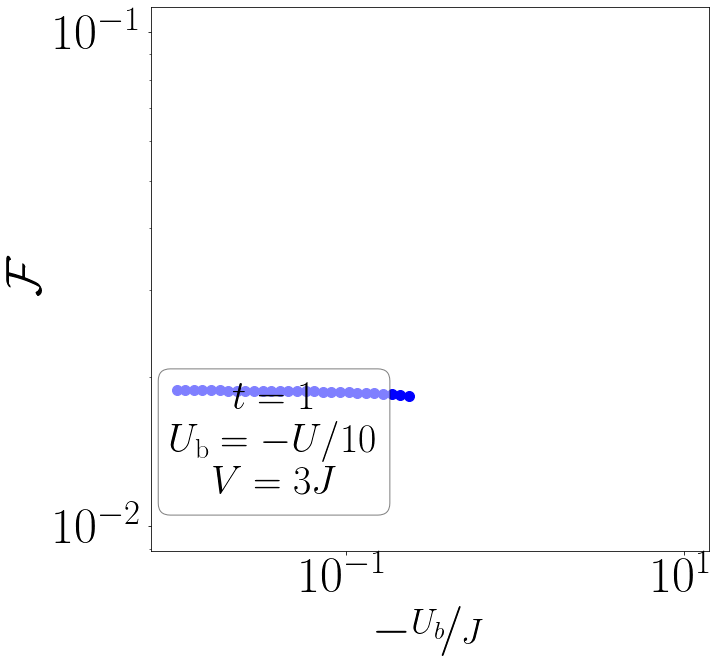

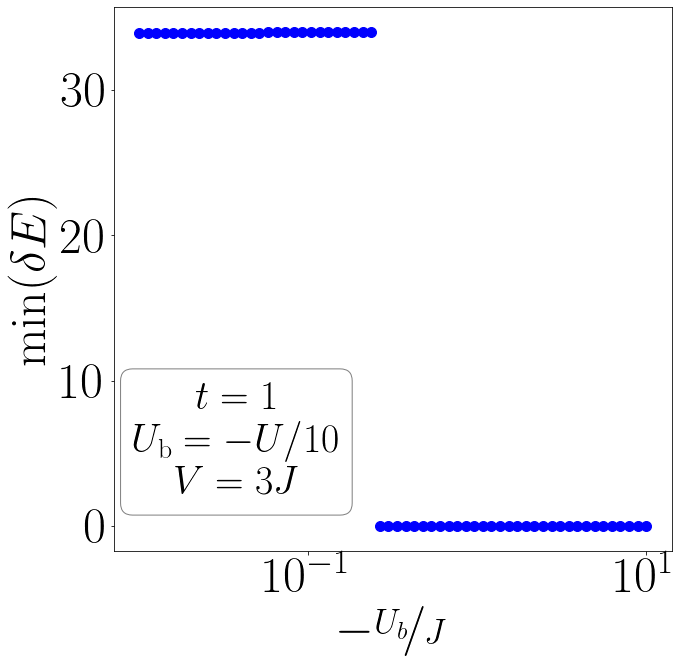

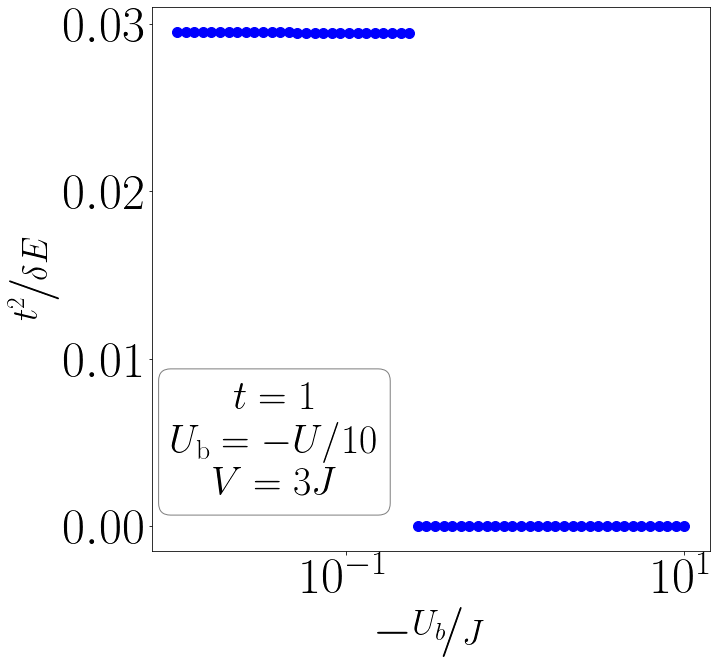

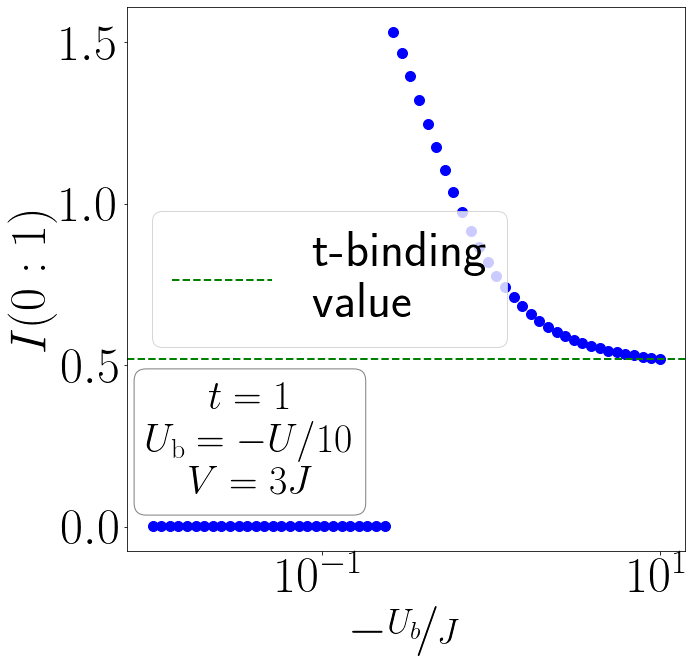

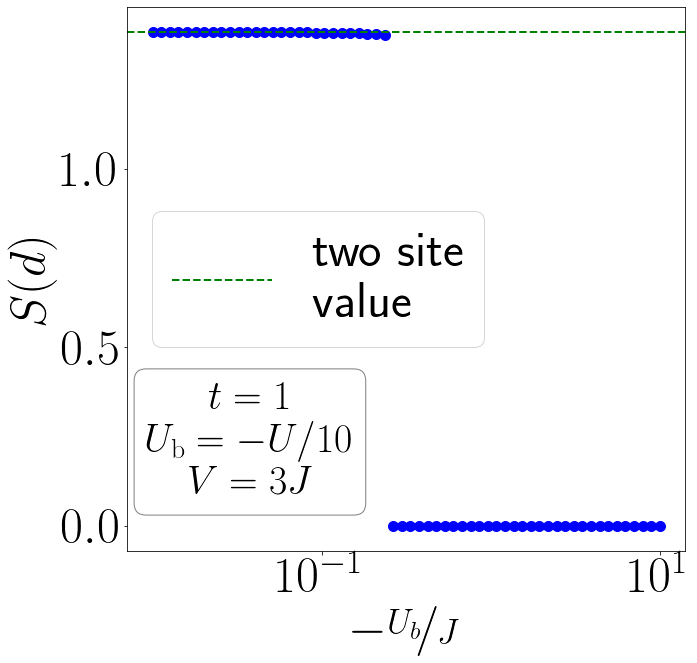

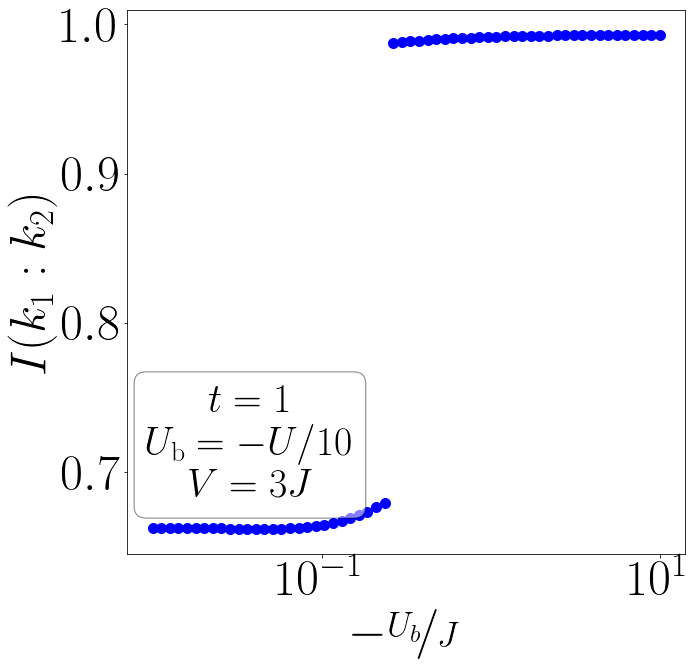

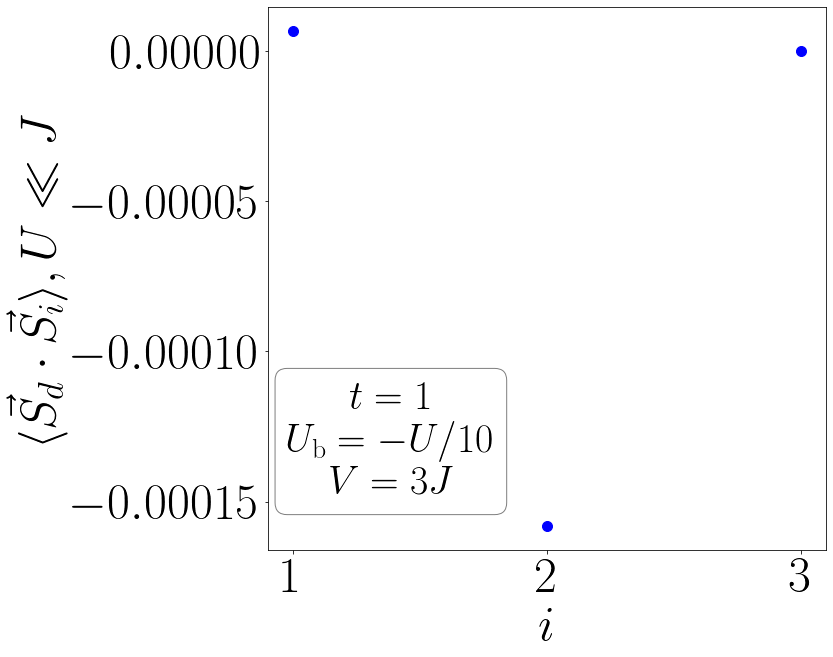

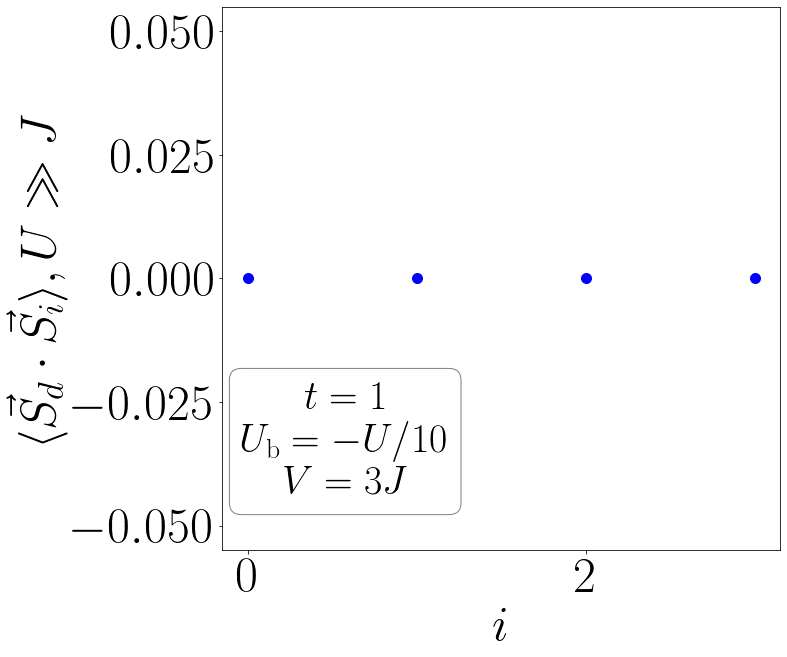

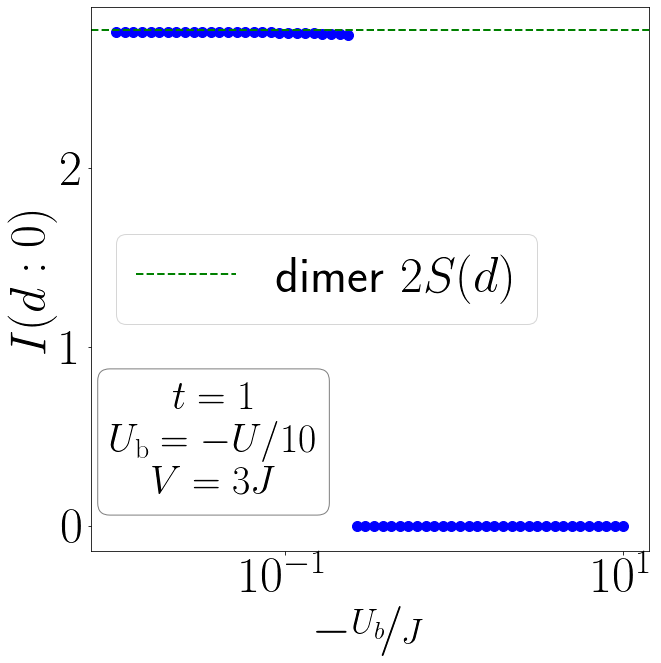

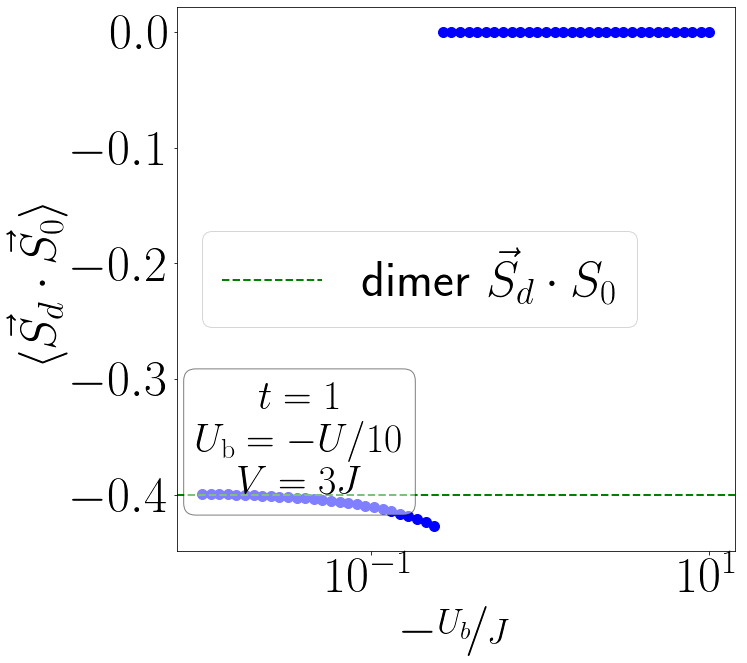

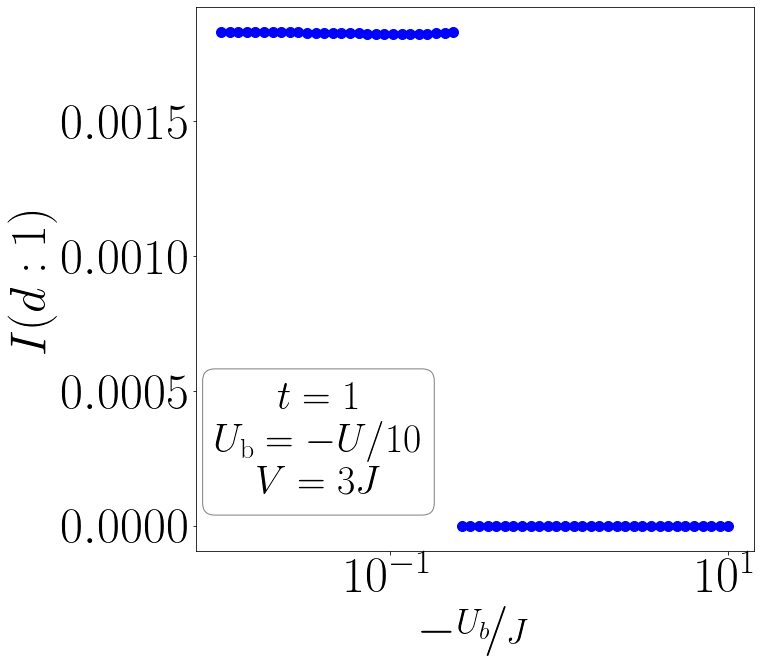

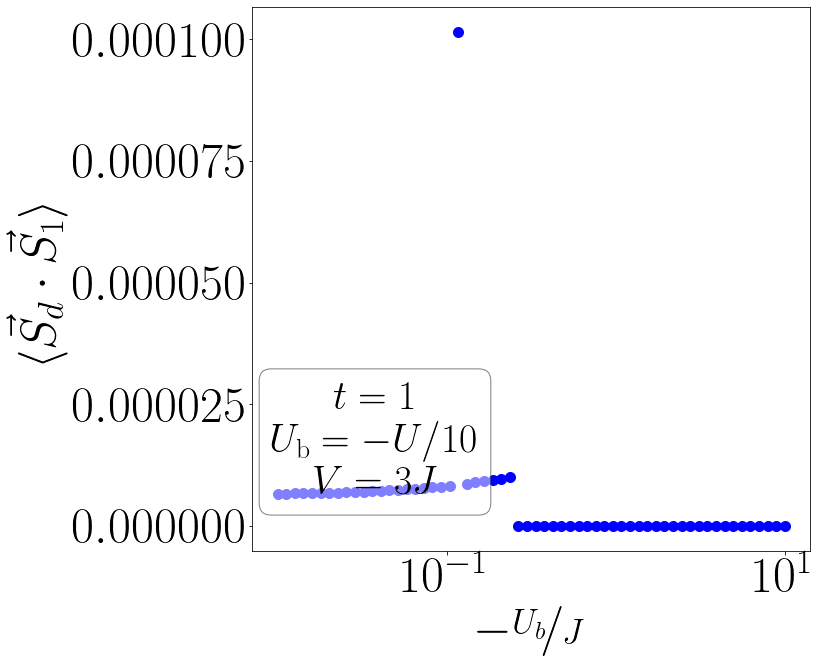

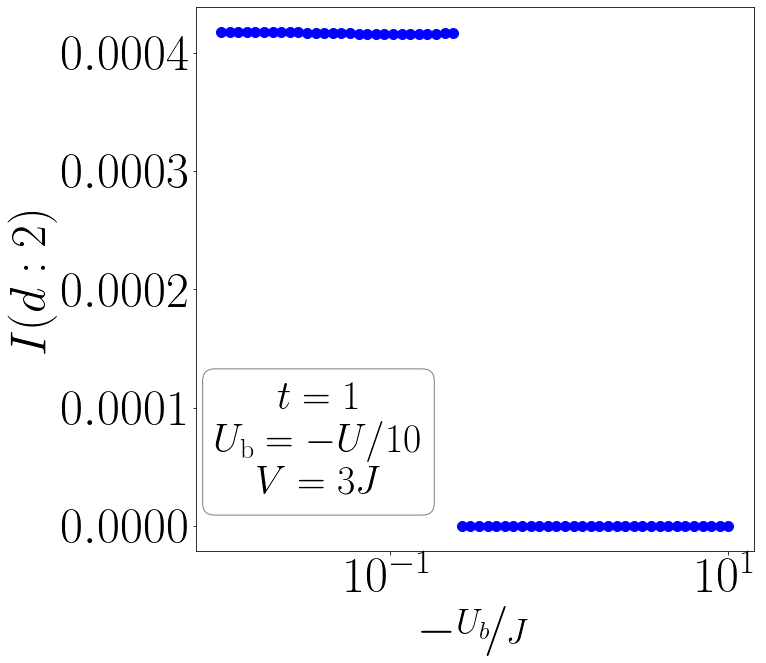

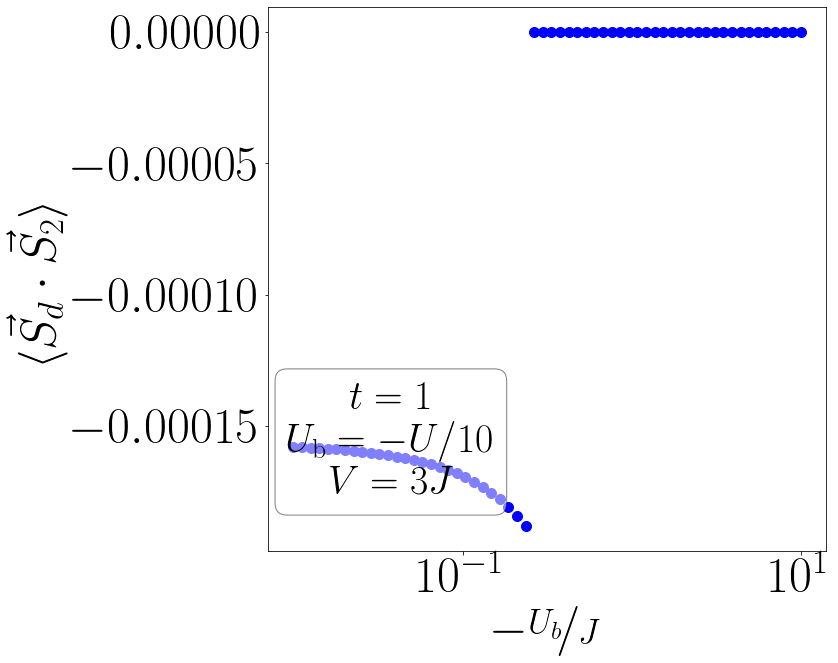

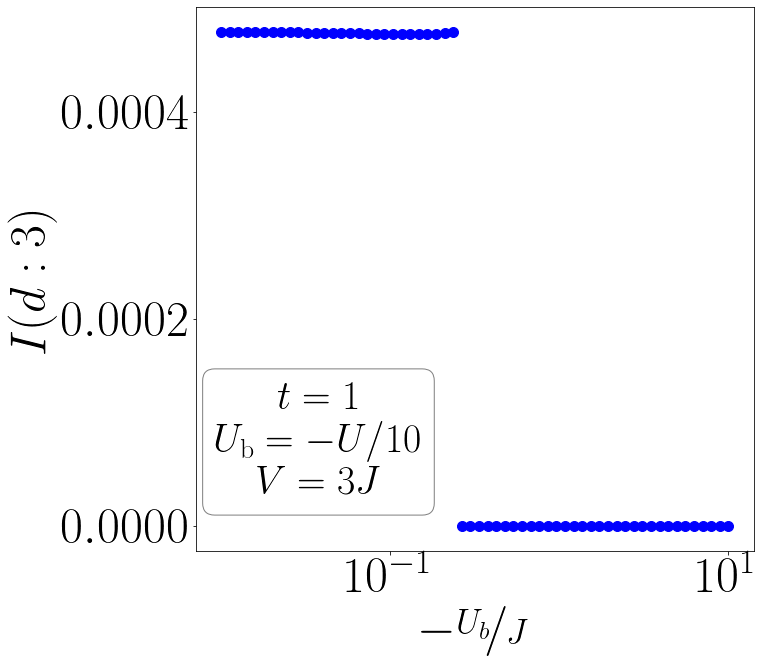

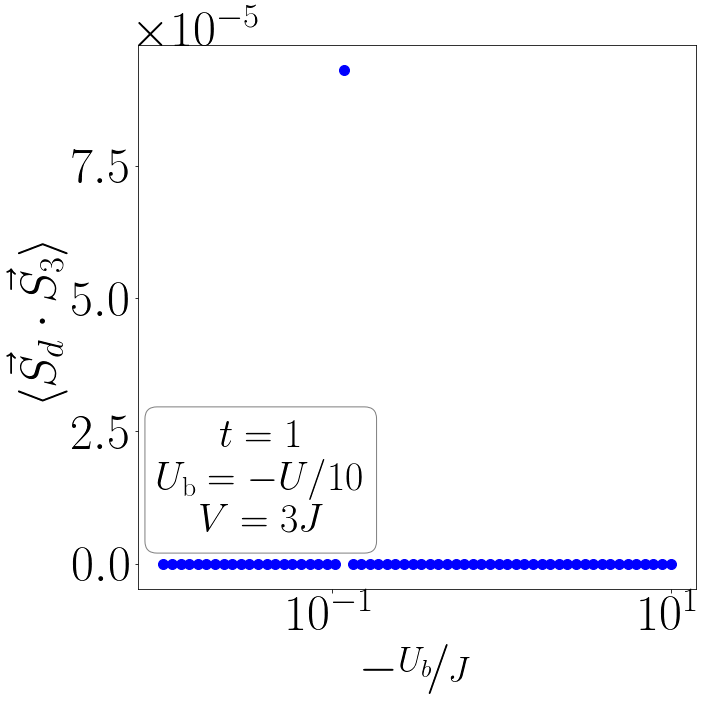

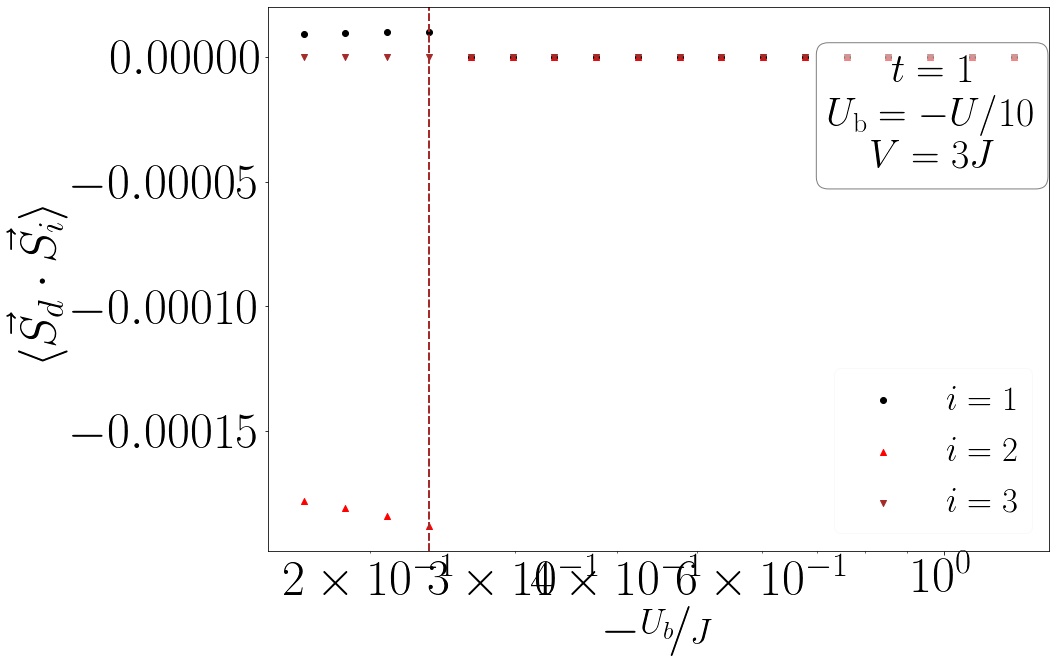

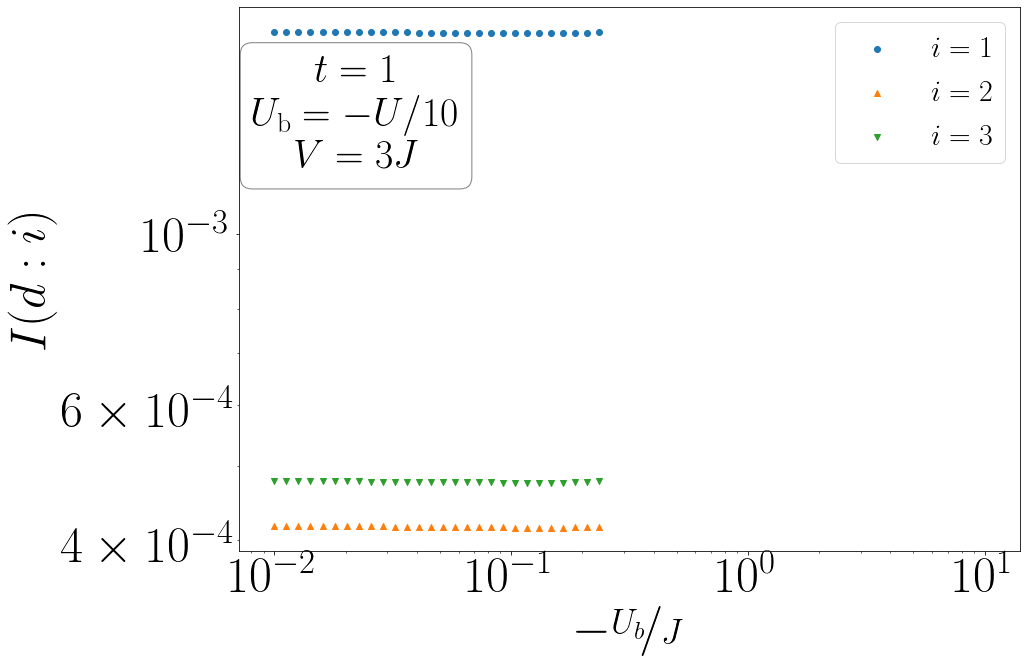

In [23]:
def gen_siam_Ub_corr():
    t = 1
    lattice_dim = 4
    J = 10
    Ubath_ = -J * 10**np.linspace(-2, 1, 60)
    J_ = J*np.ones_like(Ubath_)
    U_ = -10*np.copy(Ubath_)
    J_[-Ubath_ > J/4] = 0
    V_ = 3*np.copy(J_)
    text_str = create_text(('t', 'U_\mathrm{b}', 'V'), (t, '-U/10', '3J'))
    plot_all(t, U_, V_, J_, lattice_dim, -Ubath_/J, r"$-\nicefrac{U_b}{J}$", text_str, log_scale_x=True, log_scale_y=True, Ubath_=Ubath_,
             save="t={:.3f},J={:.3f},{:.3f},{:.0f},V=3J,Ubath=-U_by_10,N={:.0f},U={:.3f},{:.3f},{:.0f}".format(t, J_[0], J_[-1], len(J_), lattice_dim, U_[0], U_[-1], len(U_)))
    
gen_siam_Ub_corr()

# **Gen. SIAM with correlation on zeroth site**

In [ ]:
def get_U_rel_with_Ub(args):
    V0, J0 = args
    Ub = -J0*2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    return (V0, J0, 'r' if U[-1] > U0 else 'b')

## Metal-Insulator transition by varying $U_0(=-U_b)$, as discerned from the (irr)relevance of couplings

In [ ]:
def get_phase_with_Ub(args):
    U0, (w, D0, V0, J0) = args
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=-U0)
    return U0, U[-1], V[-1], J[-1]
    

def get_MIT():
    D0 = 100
    w = -D0/2
    U0 = D0/10
    J0 = D0/100
    V0 = 2*J0
    U0_range = np.linspace(0, J0*0.5, 50)
    args = product(U0_range, [(w, D0, V0, J0)])
    U_fp = list(tqdm(Pool().imap(get_phase_with_Ub, args), total=len(U0_range)))

    for U0, U, V, J in U_fp:
        plt.scatter(U0/J0, 0, marker='*', color='r' if U > U0 else 'b')
        plt.scatter(U0/J0, 1, marker='o', color='r' if V > V0 else 'b')
        plt.scatter(U0/J0, 2, marker='s', color='r' if J > J0 else 'b')

    plt.scatter([], [], marker='*', color='r', label=r'$U^*>U_0$')
    plt.scatter([], [], marker='*', color='b', label=r'$U^*<U_0$')
    plt.scatter([], [], marker='.', color='r', label=r'$V^*>V_0$')
    plt.scatter([], [], marker='.', color='b', label=r'$V^*<V_0$')
    plt.scatter([], [], marker='s', color='r', label=r'$J^*>J_0$')
    plt.scatter([], [], marker='s', color='b', label=r'$J^*<J_0$')

    plt.axvline(1/4, 0, 1, color='black', label=r'$U_0 = U_c$')
    plt.title(r"$U_b = -U_0, \nicefrac{{J_0}}{{D_0}} = {:.3f}, \nicefrac{{V_0}}{{J_0}} = {:.0f}$".format(J0/D0, V0/J0))
    plt.legend(loc='center right', fontsize=34, framealpha=0.4)
    plt.xlabel(r"$\nicefrac{{U_0}}{{J_0}}$")
    plt.yticks([])
    # plt.savefig("MIT_with_Ub.pdf", bbox_inches='tight')
    plt.show()
    
get_MIT()

## **Phase map for MIT**

In [ ]:
def get_Uc(args):
    (J0, V0), (w, D0) = args
    Ub_range = -(J0/4) * 10**np.linspace(-0.1, 0.1, 100)
    colors = []
    for Ub in Ub_range:
        E, U, V, J = complete_RG(w, D0, -10*Ub, V0, J0, Ub=Ub)
        u = np.round(U, 6)[-1]
        j = np.round(J, 6)[-1]
        v = np.round(V, 6)[-1]
        if u == 0 and v == 0 and j == 0:
            colors.append('slategray')
        elif u < j:
            colors.append('dodgerblue')
        elif u > v and u > j:
            colors.append('tomato')
        elif u < v and u > j:
            colors.append('seagreen')
        else:
            colors.append('brown')
            print (U0,u,V0,v,J0,j)
    return colors, Ub_range
    
    
def get_phasemap():
    D0 = 600
    plt.figure(figsize=(19,14))
    w = -D0/2
    J0_range = (D0) * 10**np.linspace(-4, -0.7, 120)
    V0_range = 2*J0_range
    args = product(zip(J0_range, V0_range), [(w, D0)])
    Uc = list(tqdm(Pool(30).imap(get_Uc, args), total=len(J0_range)))
    for J0, (colors, Ub_range) in zip(J0_range, Uc):
        plt.scatter(J0*np.ones_like(Ub_range)/D0, -Ub_range/J0, marker='o', s=70, color=colors)
    
    plt.plot(J0_range/D0, np.ones_like(J0_range)/4, color='black', label=r'$J_0/4 D_0$', lw=4)
    plt.scatter([], [], marker='s', s=80, color='dodgerblue', label="$U^*<V^*,J^*$")
    plt.scatter([], [], marker='s', s=80, color='tomato', label="$U^*>V^*,J^*$")
    plt.scatter([], [], marker='s', s=80, color='slategray', label="$U^*,V^*,J^*=0$")
    plt.scatter([], [], marker='s', s=80, color='seagreen', label="$J^*<U^*<V^*$")
    plt.legend(loc="upper left", fontsize=38, framealpha=0.5)
#     plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$J_0/D_0$")
    plt.ylabel(r"$-U_b/J_0$")

    txt = '\n'.join([r"$V_0 = J_0$", r"$U_0 = -10U_b$"])
    plt.text(0.8, 0.15, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("phase-map-MIT.pdf".format(D0), bbox_inches='tight')
    plt.show()
    
get_phasemap()

## Evolution of overlaps and correlations

  0%|          | 0/30 [00:00<?, ?it/s]

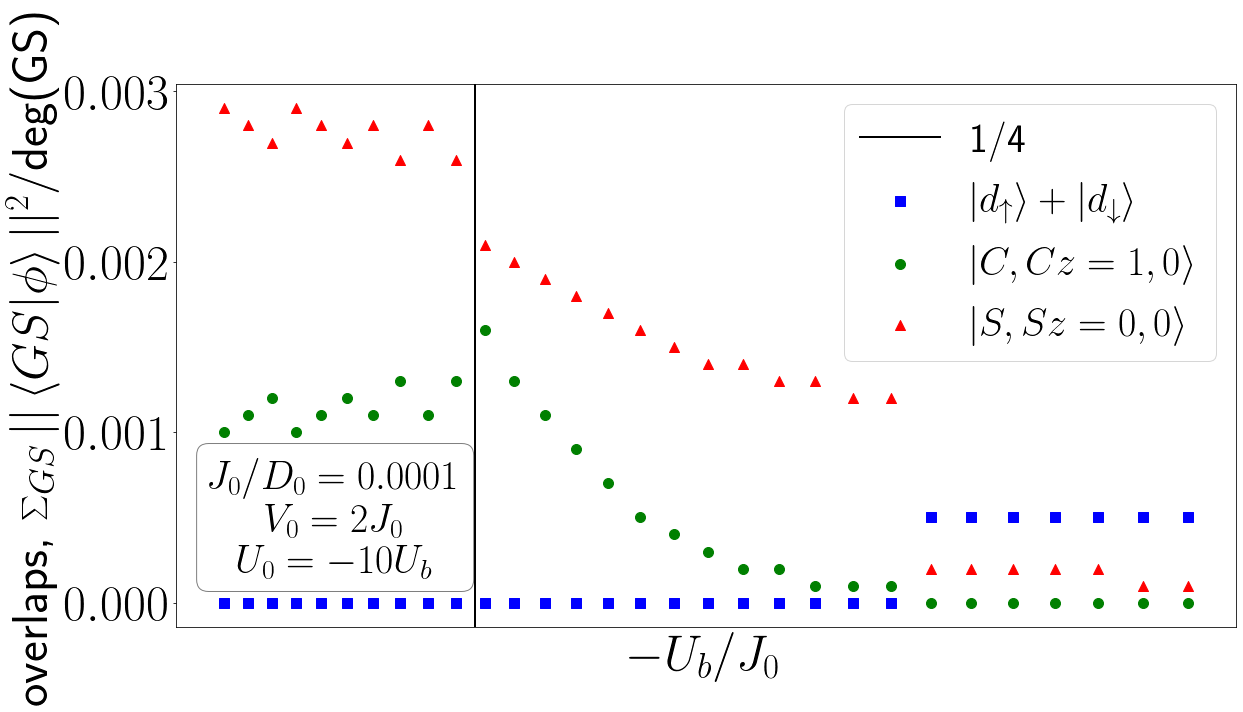

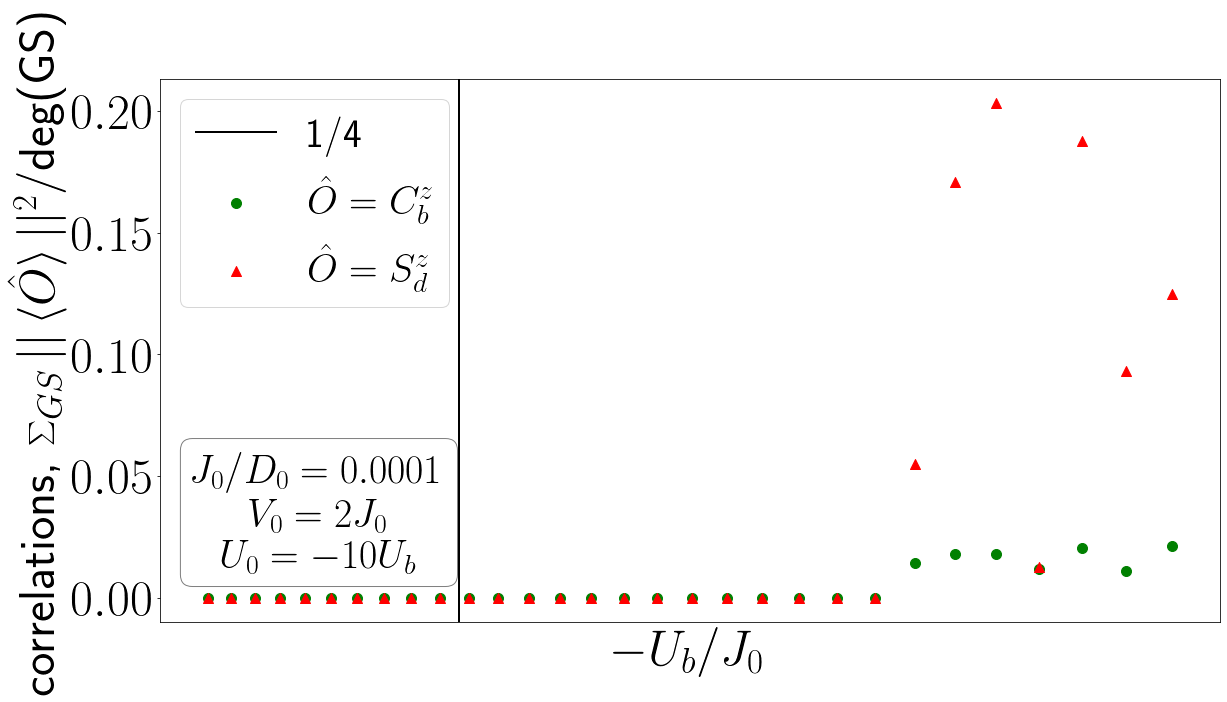

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-8-874f83577689>", line 8, in get_corr
    E, X = H.eigenstates()
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/qobj.py", line 1721, in eigenstates
    evals, evecs = sp_eigs(self.data, self.isherm, sparse=sparse,
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/sparse.py", line 409, in sp_eigs
    evals, evecs = _dense_eigs(data.todense(), isherm, vecs, N, eigvals,
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/sparse.py", line 208, in _dense_eigs
    evals, evecs 

In [8]:
def get_corr(args):
    Ub,(w,D0,V0,J0,total_dim,spin_singlet,charge_triplet_zero,lm,Sz_d,Cz_b) = args
    U0 = -10*Ub
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    u,v,j = [(0 if a[-1] < a[0]/100 else a[-1]) for a in (U,V,J)]
    t = 0.1
    H = get_full_ham(t, int((total_dim - 2)/2), u, v, j, Ubath=Ub)
    E, X = H.eigenstates()
    E = np.round(E, 5)
    C1,C2,C3,C4,C5 = 0,0,0,0,0
    for Xgs in X[E == min(E)]:
        C1 += np.abs((Xgs.dag() * spin_singlet)[0][0][0])**2 / len(X[E == min(E)])
        C2 += np.abs((Xgs.dag() * charge_triplet_zero)[0][0][0])**2 / len(X[E == min(E)])
        C3 += np.abs((Xgs.dag() * lm)[0][0][0])**2 / len(X[E == min(E)])
        C4 += np.abs((Xgs.dag() * Sz_d * Xgs)[0][0][0])**2 / len(X[E == min(E)])
        C5 += np.abs((Xgs.dag() * Cz_b * Xgs)[0][0][0])**2 / len(X[E == min(E)])
#     print (Ub/J0, j, np.round(C3, 5))
    return np.round((C1,C2,C3,C4,C5), 4)

        
def track_wf():
    D0 = 800
    Ub_min_arr = [-0.1, -0.2, -0.03]
    Ub_max_arr = [0.2, 0.2, 0.06]
    total_dim = 2*(1+5)
    w = -D0/2
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    chain = tensor([basis(2,0)]*total_dim)
    for i in range(total_dim-4):
        chain = (1 + c_all[total_dim-1-i].dag()) * chain

    spin_singlet = ((c_all[0].dag()*c_all[3].dag() - c_all[1].dag()*c_all[2].dag())*chain).unit()
    charge_triplet_zero = ((c_all[0].dag()*c_all[1].dag() + c_all[2].dag()*c_all[3].dag())*chain).unit()
    lm = ((c_all[0].dag() + c_all[1].dag())*(1 + c_all[2].dag())*(1 + c_all[3].dag())*chain).unit()
    Sz_d = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Cz_b = 0.5 * (c_all[2].dag()*c_all[2] + c_all[3].dag()*c_all[3] - 1)
    
    for J0, Ub_max, Ub_min in zip([D0*1e-4, D0*1e-2, D0/20], Ub_max_arr, Ub_min_arr):
        V0 = 2*J0
        Ub_range = -(J0/4)*10**np.linspace(Ub_min, Ub_max, 30)

        args = product(Ub_range,[[w,D0,V0,J0,total_dim,spin_singlet,charge_triplet_zero,lm,Sz_d,Cz_b]])
        C1,C2,C3,C4,C5 = [],[],[],[],[]
        Cs = list(tqdm(Pool(1).imap(get_corr, args), total=len(Ub_range)))
        for c1,c2,c3,c4,c5 in Cs:
            C1.append(c1)
            C2.append(c2)
            C3.append(c3)
            C4.append(c4)
            C5.append(c5)

        plt.figure(figsize=(19,10))
        plt.axvline(1/4, 0, 1, color='black', label="1/4")
        plt.scatter(-Ub_range/J0, C3, marker='s', color='b', s=100, label=r"$\ket{d_\uparrow}+\ket{d_\downarrow}$")
        plt.scatter(-Ub_range/J0, C2, marker='o', color='g', s=100, label=r"$\ket{C,Cz=1,0}$")
        plt.scatter(-Ub_range/J0, C1, marker='^', color='r', s=100, label=r"$\ket{S,Sz=0,0}$")
        plt.xlabel(r"$-U_b/J_0$")
        plt.ylabel(r"overlaps, $\sum_{GS}||\braket{GS | \phi}||^2 / \text{deg(GS)}$")
        txt = '\n'.join([r"$J_0/D_0 = {:.4f}$".format(J0/D0), r"$V_0 = 2J_0$", r"$U_0 = -10U_b$"])
        plt.text(0.15, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.legend(fontsize=40)
        plt.xticks([])
        plt.savefig("overlaps_gs-J={:.3f}.pdf".format(J0))
        plt.show()

        plt.figure(figsize=(19,10))
        plt.axvline(1/4, 0, 1, color='black', label="1/4")
        plt.scatter(-Ub_range/J0, C5, marker='o', s=100, color='g', label=r"$\hat O = C^z_b$")
        plt.scatter(-Ub_range/J0, C4, marker='^', s=100, color='r', label=r"$\hat O = S_d^z$")
        plt.xlabel(r"$-U_b/J_0$")
        plt.ylabel(r"correlations, $\sum_{GS}||\braket{\hat O}||^2 / \text{deg(GS)}$")
        txt = '\n'.join([r"$J_0/D_0 = {:.4f}$".format(J0/D0), r"$V_0 = 2J_0$", r"$U_0 = -10U_b$"])
        plt.text(0.15, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.legend(loc=2,fontsize=40)
        plt.xticks([])
        plt.savefig("corrs_gs-J={:.3f}.pdf".format(J0))
        plt.show()

track_wf()

## Metal spectral function

## $A_{dd}(\omega)$

In [ ]:
def SF_dd():
    plt.rcParams.update({'font.size': 40})
    delta = 1
    N0 = 2
    rho0 = 0.1
    deltaE = N0/rho0
    D = deltaE
    t = D
    Nk = 5
    a = 1
    k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
    non_int_ht = 1/(2*np.pi*delta)
    N_w = 2000
    w_cut = delta*0.5

    U_range = np.array([0.5, 8, 15, 30])
    J_range = np.array([0.5, 5.5, 8, 30*4/10])

    for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
        Ub = -U/10
        w_max = 7*delta + U
        w_range = np.linspace(-w_max, w_max, N_w)*delta
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        A = spec_func_U((Ek_0, U, V, J), delta, w_range, non_int_ht, Ubath=Ub)
        plt.plot(w_range/delta, A, 'b', lw=3)
        txt = '\n'.join([r'$\nicefrac{{U_b}}{{J}}={:.3f}$'.format(Ub/J), r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U_b}}{{U}}={:.1f}$'.format(Ub/U)])
        plt.text(0.22, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.xlabel("$\omega/\Delta$")
        plt.ylabel("$A_{dd}(\omega)$")
        plt.savefig("spec_func_Ub_by_J={:.3f}.pdf".format(Ub/J), bbox_inches='tight')
        plt.show()

SF_dd()

## $A_{dz}(\omega)$

In [ ]:
def SF_dz():
    plt.rcParams.update({'font.size': 40})
    delta = 1
    N0 = 2
    rho0 = 0.1
    deltaE = N0/rho0
    D = deltaE
    t = D
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
    non_int_ht = 1/(2*np.pi*delta)
    N_w = 2000
    U_range = np.array([0.2, 8, 15, 30])
    J_range = np.array([0.2, 5.5, 8, 30*4/10])

    for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
        Ub = -U/10
        w_max = 7*delta + U
        w_range = np.linspace(-w_max, w_max, N_w)*delta
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        A = spec_func_U((Ek_0, U, V, J), delta, w_range, non_int_ht, exc=(0,2), Ubath=Ub) 
        plt.plot(w_range/delta, A, 'b', lw=3)
        txt = '\n'.join([r'$\nicefrac{{U_b}}{{J}}={:.3f}$'.format(Ub/J), r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U_b}}{{U}}={:.1f}$'.format(Ub/U)])
        plt.text(0.22, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.xlabel("$\omega/\Delta$")
        plt.ylabel("$A_{d0}(\omega)$")
        plt.savefig("spec_func_d0_Ub_by_J={:.3f}.pdf".format(Ub/J), bbox_inches='tight')
        plt.show()

SF_dz()

## $A_{zz}(\omega)$

In [ ]:
def SF_zz():
    plt.rcParams.update({'font.size': 40})
    delta = 1
    N0 = 2
    rho0 = 0.1
    deltaE = N0/rho0
    D = deltaE
    t = 30
    Nk = 5
    a = 1
    k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
    non_int_ht = 1/(2*np.pi*delta)
    N_w = 2000
    J = 0.1
    Ub_range = -J * np.linspace(0, 0.25, 3)

    for Ub in tqdm(Ub_range):
        U = -10*Ub
        w_max = 100*delta
        w_range = np.linspace(-w_max, w_max, N_w)*delta
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        A = spec_func_U((Ek_0, U, V, J), delta, w_range, non_int_ht, exc=(2,2), Ubath=Ub, ht_flag=False) 
        plt.plot(w_range/delta, A, 'b', lw=3)
        txt = '\n'.join([r'$\nicefrac{{U_b}}{{J}}={:.2f}$'.format(Ub/J), r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U_b}}{{U}}={:.1f}$'.format(Ub/U if U != 0 else 0)])
        plt.text(0.22, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.xlabel("$\omega/\Delta$")
        plt.ylabel("$A_{d0}(\omega)$")
        plt.savefig("spec_func_00_Ub_by_J={:.3f}.pdf".format(Ub/J), bbox_inches='tight')
        plt.show()

SF_zz()

### Width

In [ ]:
def get_width(args):
    (U,J,V),delta,Ek_0 = args
    N_w = 2000
    w_cut = delta/2
    non_int_ht = 1/(2*np.pi*delta)
    w_max = 5*delta + U*5
    w_range = np.linspace(-w_max, w_max, N_w)*delta
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    A = spec_func_U((Ek_0, U, V, J), delta, w_range, non_int_ht, Ubath=-U/10)
    return peak_widths(A, [int(N_w/2)])[0][0]*(w_range[1] - w_range[0])


def fit_func(x, b, c):
    return np.exp(-b*x**1-c*x**2.5)


def get_fwhm_Ub():
    delta = 1
    N0 = 2
    rho0 = 0.1
    deltaE = N0/rho0
    D = deltaE
    t = D
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
    
    J = 10
    num_points = 100
    U_range = (J/4)*10**np.linspace(-3, 0, num_points)*delta
    J_range = J*10**np.linspace(-2.5, 0, num_points)*delta
    V_range = 1.2 * J_range

    fname = "./Tk_data/Nk={},U={:.4f},{:.4f},{:.0f},J={:.4f},{:.4f},{:.0f},V={:.4f},{:.4f},{:.0f}".format(
        int(Nk), U_range[0], U_range[-1], len(U_range), J_range[0],
        J_range[-1], len(J_range), V_range[0],V_range[-1], len(V_range))
    if os.path.exists(fname+".npy"):
        width = np.load(fname+".npy")
    else:
        args = product(zip(U_range, J_range, V_range), [delta], [Ek_0])
        width = list(tqdm(map(get_width, args), total=len(U_range)))
        np.save(fname, width, allow_pickle=True)

    plt.scatter((U_range/J_range)[::2], width[::2], color='g', s=50, marker='o', label=r'width')

    params, _ = curve_fit(fit_func, U_range/J_range, width)
    fit_y = [fit_func(x,*params) for x in U_range/J_range]
    plt.plot(U_range/J_range, fit_y, lw=3, color='b', label='\n'.join([r'$e^{-bx-cx^{2.5}}$', r'$x=\nicefrac{U}{J}$']))

    plt.xscale("log")
    plt.xlabel(r"$U/J$")
    plt.ylabel(r"FWHM")
    plt.legend()
    plt.savefig("spec_func_width_fit.pdf", bbox_inches='tight')
    plt.show()
    
get_fwhm_Ub()

## Local moment spectral function

## $A_{dd}(\omega)$

In [ ]:
def SF_lm_dd():
    delta = 1
    t = 1
    rho = 0.1
    Nk = 5
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = J = 0
    U = 50
    Ub = -U/10
    w_max = U*1.5
    N_w = 2000
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=Ub)
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    O_up = c_all[0]
    Z = len(X0)
    A = 0
    for En, Xn in tqdm(zip(E, X), total=len(E)):
        for Xgs in X0:
            C1 = Xgs.dag()*O_up*Xn
            C1_sq = np.real((C1*C1.dag())[0][0][0])
            C2 = Xn.dag()*O_up*Xgs
            C2_sq = np.real((C2*C2.dag())[0][0][0])
            eta = 1 + 0.35 * np.abs(w_range)
            x1 = w_range + E[0] - En
            x2 = w_range + En - E[0]
            A += (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
            A /= Z

    A = 0.5*(A + np.flip(A))
    A /= np.trapz(A, x=w_range)
    A = np.round(A, 5)
    plt.plot(w_range, A, 'b', lw=3)
    txt = '\n'.join([r'$\nicefrac{{U_b}}{{J}}={:.3f}$'.format(-0.260), r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U_b}}{{U}}={:.1f}$'.format(Ub/U)])
    plt.text(0.22, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.savefig("spec_func_Ub_by_J={:.2f}.pdf".format(-0.260), bbox_inches='tight')
    plt.show()
        
SF_lm_dd()

## $A_{dz}(\omega)$

In [ ]:
def SF_lm_dz():
    U = 50
    Ub = -U/10
    V = J = 0
    delta = 1
    t = 1
    rho = 0.1
    Nk = 5
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    w_max = U*1.5
    N_w = 2000
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=Ub)
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    O1_up = c_all[0]
    O2_up = sum([c_all[i] for i in range(2, total_dim-1, 2)]).dag()/(total_dim/2-1)
    Z = len(X0)
    A = 0
    for En, Xn in tqdm(zip(E, X), total=len(E)):
        for Xgs in X0:
            C1_sq = np.abs(np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0]))
            C2_sq = np.abs(np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0]))
            eta = 1 + 0.35 * np.abs(w_range)
            x1 = w_range + E[0] - En
            x2 = w_range + En - E[0]
            A += (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
            A /= Z

    A = 0.5*(A + np.flip(A))
    A = np.round(A, 5)
    plt.plot(w_range, A, 'b', lw=3)
    txt = '\n'.join([r'$\nicefrac{{U_b}}{{J}}={:.3f}$'.format(-0.260), r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U_b}}{{U}}={:.1f}$'.format(Ub/U)])
    plt.text(0.22, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.savefig("spec_func_d0_Ub_by_J={:.2f}.pdf".format(-0.260), bbox_inches='tight')
    plt.show()
    
SF_lm_dz()

## $A_{00}(\omega)$

In [ ]:
def SF_lm_zz():
    U = 50
    Ub = -U/10
    V = J = 0
    delta = 1
    t = 1
    rho = 1
    Nk = 5
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    w_max = U
    N_w = 2000
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=-U)
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    O1_up = sum([c_all[i] for i in range(2, total_dim-1, 2)])/(total_dim/2-1)
    O2_up = O1_up.dag()
    Z = len(X0)
    A = 0
    for En, Xn in tqdm(zip(E, X), total=len(E)):
        for Xgs in X0:
            C1_sq = np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0])
            C2_sq = np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0])
            eta = 10 + 0.35 * np.abs(w_range)
            x1 = w_range + E[0] - En
            x2 = w_range + En - E[0]
            A += (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
            A /= Z

    A = 0.5*(A + np.flip(A))
    A /= np.trapz(A, x=w_range)
#     A = np.round(A, 5)
    plt.plot(w_range, A, 'b', lw=3)
    txt = '\n'.join([r'$\nicefrac{{U_b}}{{J}}={:.3f}$'.format(-0.260), r'$\Delta={:.1f}$'.format(delta), r'$\nicefrac{{U_b}}{{U}}={:.1f}$'.format(Ub/U)])
    plt.text(0.22, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.legend()
    plt.savefig("spec_func_00_Ub_by_J={:.2f}.pdf".format(-0.26), bbox_inches='tight')
    plt.show()
    
SF_lm_zz()

## Self-energy

In [ ]:
def read_Add(basename):
    try:
        Add = np.load("./sigma_data/sigma-A-" + basename + ".npy")
    except:
        Add = [False]
    return Add


def read_Ad0(basename):
    try:
        Ad0 = np.load("./sigma_data/sigma-Ad0-" + basename + ".npy")
    except:
        Ad0 = [False]
    return Ad0
    

def read_EX(basename):
    try:
        E = qload("./sigma_data/sigma-E-" + basename)
        X = qload("./sigma_data/sigma-X-" + basename)
        return E, X
    except:
        return [False], [False]
        
        
def read_z(basename):
    try:
        z = np.load("./sigma_data/sigma-z-" + basename + ".npy")
        return z
    except:
        return [False]
        

def plot_sigma4(args, lm=['n']*4):
    assert not False in [lm_i == 'y' or lm_i == 'n' for lm_i in lm]
    x, y, vals, z_s, r = args
    fig, ax = plt.subplots(2,2,figsize=(24,18))
    axs = [ax[i][j] for i,j in product(range(2), range(2))]
    for i,(ax_i,z,val) in enumerate(zip(axs,z_s,vals)):
        c = ax_i.imshow(z, cmap='RdBu', aspect='auto', origin='lower')
        fig.colorbar(c, ax=ax_i)
        ax_i.plot([0, 1], [1, 0], transform=ax_i.transAxes, ls="--", lw="3", color='black')
        ax_i.set_xlabel(r"$k_x$")
        ax_i.set_ylabel(r"$k_y$")
        if lm[i] == "y":
            ax_i.set_title(r'$|\text{{Im}}[\Sigma^{{-1}}\left(\omega/U={:.2f}\right)]|$'.format(val), size=40)
        else:
            ax_i.set_title(r'$|\text{{Im}}[\Sigma\left(\omega/U={:.2f}\right)]|$'.format(val), size=40)
    plt.suptitle(r"$\nicefrac{{U_b}}{{J}}={:.4f}, U = -10 U_b, \{{\nicefrac{{4U_b}}{{J}}\}} = [0.1, 1]$".format(r), y=0.94)
    fig.tight_layout()
    plt.close()
    return [fig, "./plots/sigma-4-Ub_by_J={:.5f}-4.pdf".format(r)]
    
    
    
def plot_sigma(args):
    x, y, z1, z4, (w_range, Add), (w_range2, Ad0), r, lm = args
    fig, ax = plt.subplots(2,2,figsize=(24,18))
    ax1, ax2, ax3, ax4 = ax[0][0],ax[0][1],ax[1][0],ax[1][1],
    c1 = ax1.imshow(z1, cmap='RdBu', aspect='auto', origin='lower')
    c2 = ax2.imshow(z4, cmap='RdBu', aspect='auto', origin='lower')
    fig.colorbar(c1, ax=ax1)
    fig.colorbar(c2, ax=ax2)
    ax1.plot([0, 1], [1, 0], transform=ax1.transAxes, ls="--", lw="3", color='black')
    ax2.plot([0, 1], [1, 0], transform=ax2.transAxes, ls="--", lw="3", color='black')
    ax3.plot(w_range, Add)
    ax4.plot(w_range2, Ad0)
    
    ax1.set_xlabel(r"$k_x$")
    ax1.set_ylabel(r"$k_y$")
    ax2.set_xlabel(r"$k_x$")
    ax2.set_ylabel(r"$k_y$")
    ax3.set_xlabel(r"$\omega/U$")
    ax3.set_ylabel(r"$A_{dd}(\omega)$")
    ax4.set_xlabel(r"$\omega/U$")
    ax4.set_ylabel(r"$A_{d0}(\omega)$")

    if lm[0] == "y":
        ax1.set_title(r'$|\text{{Im}}[\Sigma^{{-1}}\left(\omega/U=0\right)]|$', size=40)
    else:
        ax1.set_title(r'$|\text{{Im}}[\Sigma\left(\omega/U=0\right)]|$', size=40)
    if lm[1] == "y":
        ax2.set_title(r'$|\text{{Im}}[\Sigma^{{-1}}\left(\omega/U=1/2\right)]|$', size=40)
    else:
        ax2.set_title(r'$|\text{{Im}}[\Sigma\left(\omega/U=1/2\right)]|$', size=40)
        
    ax3.axvline(0, 0, 1, ls="--", color='r')
    ax3.axvline(0.5, 0, 1, ls="--", color='g')
    
    ax4.axvline(0, 0, 1, ls="--", color='r')
    ax4.axvline(0.5, 0, 1, ls="--", color='g')
    plt.suptitle(r"$\nicefrac{{U_b}}{{J}}={:.4f}, U = -10 U_b, \{{\nicefrac{{4U_b}}{{J}}\}} = [0.1, 1]$".format(r), y=0.94)
    fig.tight_layout()
    plt.close()
    return [fig, "./plots/sigma-Ub_by_J={:.5f}.pdf".format(r)]


def get_Gdd(w_range, E, X, eta):
    E = np.round(E, 5)
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    G_dd = 0
    for En,Xn in zip(E,X):
        for X0 in X[E == min(E)]:
            G_dd += np.abs((Xn.dag() * c_all[0].dag() * X0)[0][0][0])**2 / (w_range + min(E) - En + 1j*eta)
            G_dd += np.abs((X0.dag() * c_all[0].dag() * Xn)[0][0][0])**2 / (w_range - min(E) + En + 1j*eta)
    return G_dd


def get_Gd0(w_range, E, X, eta):
    E = np.round(E, 5)
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    c0 = sum([c_all[i] for i in range(2, total_dim-1, 2)])/(total_dim/2-1)
    G_d0 = 0
    for En,Xn in zip(E,X):
        for X0 in X[E == min(E)]:
            G_d0 += ((X0.dag() * c_all[0] * Xn) * (Xn.dag() * c0.dag() * X0))[0][0][0] / (w_range + min(E) - En + 1j*eta)
            G_d0 += ((Xn.dag() * c_all[0] * X0) * (X0.dag() * c0.dag() * Xn))[0][0][0] / (w_range - min(E) + En + 1j*eta)
    return G_d0


def get_sigma_imag(args):
    xi_k_arr, Gdd, Gd0, Ek_aux_arr, V, omega, w, w_range, delta, eta, lm = args
    G00_0 = np.sum([1/(w_range - Ek + 1j*eta) for Ek in Ek_aux_arr])
    Gdd_0 = 1/(w_range + 1j*(delta+eta))
    Gd0_0 = G00_0 * V * Gdd_0
    sigma_k = lambda x: (1/(Gdd_0 + x*Gd0_0/w) + 1/(Gdd + x*Gd0/w))[w_range <= omega][-1]
    if lm != "-y":
        sigma_kw_arr = [np.imag(sigma_k(np.abs(xi_k))) for xi_k in xi_k_arr]
    else:
        sigma_kw_arr = [np.imag(1/sigma_k(np.abs(xi_k))) for xi_k in xi_k_arr]
    return sigma_kw_arr


def get_EX(Ek_aux_arr,U,V,J,Ub,basename,w_range):
    H = get_ham_K(Ek_aux_arr, -U/2, U, V, J, Ubath=Ub)
    E, X = H.eigenstates()
    qsave(E, "./sigma_data/sigma-E-" + basename)
    qsave(X, "./sigma_data/sigma-X-" + basename)
    return E,X
                
                
                
def get_z(params, omega):
    xi_k_arr_arr,eta,delta,w,t,Ek_aux_arr,U,V,J,Ub,basename,w_range,lm = params
    Nk = len(Ek_aux_arr)
    basename_EX = 'delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f}'\
                  .format(delta,eta,t,Nk,U,-U/10,J,V)
    E,X = read_EX(basename_EX)
    if False in E and False in X: E,X = get_EX(Ek_aux_arr,U,V,J,Ub,basename_EX,w_range)
    Gdd = get_Gdd(w_range, E, X, eta)
    Gd0 = get_Gd0(w_range, E, X, eta)
    args = product(xi_k_arr_arr, [Gdd], [Gd0], [Ek_aux_arr], [V], [omega], [w], [w_range], [delta], [eta], [lm])
    z = np.abs(list((Pool().imap(get_sigma_imag, args))))
    np.save("./sigma_data/sigma-z-" + basename + lm + ".npy", z)
    return z
    
    
def get_A(params):
    Nk,t,U,V,J,delta,Umax,exc = params
    Ub = -U/10
    k_aux_arr = np.linspace(0, 2*np.pi, Nk)
    Ek_aux_arr = -2*t*np.cos(k_aux_arr)
    N_w = 2000
    w_max = Umax if abs(Ub/J) > 0.2 else Umax/1.9
    non_int_ht = 1/(2*np.pi*delta)
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    basename = 'wmin={:.2f},wmax={:.2f},N_w={:.0f},delta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f}'\
    .format(min(w_range),max(w_range),len(w_range),delta,t,Nk,U,-U/10,J,V)
    A = read_Add(basename) if exc == (0,0) else read_Ad0(basename)
    if False in A:
        try:
            A = spec_func_U((Ek_aux_arr, U, V, J), delta, w_range, non_int_ht, Ubath=Ub, exc=exc)
            np.save("./sigma_data/sigma-A" + ("" if exc==(0,0) else "d0") + "-" + basename + ".npy", A)
        except:
            print (1)
            pass
    return w_range/Umax,A


def get_A_lm(w_range, delta, eta, t, Ek_aux_arr, U, V, J, Ub, exc, basename):
    Nk = len(Ek_aux_arr)
    basename_EX = 'delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f}'\
                  .format(delta,eta,t,Nk,U,Ub,J,V)
    try:
        E = qload("./sigma_data/sigma-E-" + basename_EX)
        X = qload("./sigma_data/sigma-X-" + basename_EX)
    except:
        H = get_ham_K(Ek_aux_arr, -U/2, U, V, J, Ubath=Ub)
        E, X = H.eigenstates()
        qsave(E, "./sigma_data/sigma-E-" + basename_EX)
        qsave(X, "./sigma_data/sigma-X-" + basename_EX)

    if exc == (0,0):
        G = get_Gdd(w_range, E, X, eta)
    else:
        G = get_Gd0(w_range, E, X, eta)
    A = -(1/np.pi)*np.imag(G)
    np.save("./sigma_data/sigma-lm-A" + ("" if exc==(0,0) else "d0") + "-" + basename + ".npy", A)
    return A


def plot_sigma_A():
    w = 4
    t = 1
    Nk = 4
    J = 1
    V = 2*J
    eta = 0.1
    delta = 1
    non_int_ht = 1/(2*np.pi*delta)
    U_range = 10*(J/4)/(10**(np.linspace(0, 1, 100)**3))
    Umax = max(U_range)
    w_range = np.linspace(0, 3*Umax/4, 100)
    J_range = J*np.ones_like(U_range)
    k_aux_arr = np.linspace(0, 2*np.pi, Nk)
    Ek_aux_arr = -2*t*np.cos(k_aux_arr)
    k_arr = np.linspace(0, np.pi, 200)
    xi_k_arr_arr = [2 * (np.cos(kx) + np.cos(k_arr)) for kx in k_arr]
    basenames = [['delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f},loc={:.2f}'\
                  .format(delta,eta,t,Nk,U,-U/10,J,V,loc) for U,J in zip(U_range, J_range)] for loc in [0, 0.5]]
    x, y = np.meshgrid(k_arr, k_arr)
    params = [[[xi_k_arr_arr,eta,delta,w,t,Ek_aux_arr,U,V,J,-U/10,basename,w_range,""] for i,(U,J,basename) in enumerate(zip(U_range, J_range, basenames[loc]))] for loc in range(2)]

    z1_arr = [(z if False not in z else get_z(params[0][i],0)) for i,z in enumerate(tqdm(Pool().imap(read_z, basenames[0]), desc="z1", total=len(basenames[0])))]
    z4_arr = [(z if False not in z else get_z(params[1][i],0.5*Umax)) for i,z in enumerate(tqdm(Pool().imap(read_z, basenames[1]), desc="z4", total=len(basenames[0])))]
    
    t_new = 40
    J_new = np.linspace(40*4/10, 0.5, len(U_range))
    U_new = J_new * U_range / J_range
    
    t_new2 = 10
    delta2 = 1.4
    J_new2 = np.linspace(60*4/10, 0.2, len(U_range))
    U_new2 = U_range * J_new2 / J_range
    
    params1 = [[Nk,t_new,U,V,J,delta,max(U_new),(0,0)] for U,J in zip(U_new,J_new)]
    params2 = [[Nk,t_new2,U,V,J,delta2,max(U_new2),(0,2)] for U,J in zip(U_new2,J_new2)]
    
    A_arr = list(tqdm(map(get_A, params1), desc="Add", total=len(params1)))
    A_arr2 = list(tqdm(map(get_A, params2), desc="Ad0", total=len(params2)))

    figs = list(tqdm(Pool().imap(plot_sigma, zip([x]*len(z1_arr), [y]*len(z1_arr), z1_arr, z4_arr, A_arr, A_arr2, -0.1*U_range/J_range, ["nn"]*len(z1_arr))), desc="plot", total=len(U_range)))
    for fig,savename in tqdm(figs, desc="plot"):
        fig.savefig(savename, bbox_inches='tight')
    
    J_old = 10
    J = V = 0
    delta = 0
    for r in tqdm(np.linspace(0.2501, 0.26, 3), desc="lm"):
        Ub = -J_old*r
        U = -10*Ub
        w_max = U
        N_w = 2000
        w_range = np.linspace(-w_max, w_max, N_w)
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        eta = 0.8
        basenames = ['delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f},loc={:.2f}'\
                  .format(delta,eta,t,Nk,U,-U/10,J,V,loc) for loc in [0, 0.5]]
        params = [[xi_k_arr_arr,eta,delta,w,t,Ek_aux_arr,U,V,J,Ub,basenames[loc],w_range] for loc in range(2)]
        
        z1 = read_z(basenames[0]+"-y")
        if False in z1: z1 = get_z(params[0]+["-y"],0)

        z2 = read_z(basenames[1]+"")
        if False in z2: z2 = get_z(params[1]+[""],3*Umax/6)
       
        basename = 'wmin={:.2f},wmax={:.2f},N_w={:.0f},delta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f}'\
        .format(min(w_range),max(w_range),len(w_range),delta,t,Nk,U,-U/10,J,V)
        try:
            Add = np.load("./sigma_data/sigma-lm-A-" + basename + ".npy")
        except:
            Add = get_A_lm(w_range, delta, eta, t, Ek_aux_arr, U, V, J, Ub, (0,0), basename)
        try:
            Ad0 = np.load("./sigma_data/sigma-lm-Ad0-" + basename + ".npy")
        except:
            Ad0 = get_A_lm(w_range, delta, eta, t, Ek_aux_arr, U, V, J, Ub, (0,1), basename)

        fig,savename = plot_sigma((x, y, z1, z2, (w_range/U,Add), (w_range/U,Ad0), Ub/J_old, "yn"))
        fig.savefig(savename, bbox_inches='tight')
        
        
def plot_sigma_four():
    w = 4
    t = 1
    Nk = 4
    J = 1
    V = 2*J
    eta = 0.1
    delta = 1
    non_int_ht = 1/(2*np.pi*delta)
    U_range = 10*(J/4)/(10**(np.linspace(0, 1, 100)**3))
    Umax = max(U_range)
    w_range = np.linspace(0, 3*Umax/4, 100)
    J_range = J*np.ones_like(U_range)
    k_aux_arr = np.linspace(0, 2*np.pi, Nk)
    Ek_aux_arr = -2*t*np.cos(k_aux_arr)
    k_arr = np.linspace(0, np.pi, 200)
    xi_k_arr_arr = [2 * (np.cos(kx) + np.cos(k_arr)) for kx in k_arr]
    locs = [0, 0.1, 0.2, 0.5]
    basenames = [['delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f},loc={:.2f}'\
                  .format(delta,eta,t,Nk,U,-U/10,J,V,loc) for U,J in zip(U_range, J_range)] for loc in locs]
    x, y = np.meshgrid(k_arr, k_arr)
    params = [[[xi_k_arr_arr,eta,delta,w,t,Ek_aux_arr,U,V,J,-U/10,basename,w_range,""] for i,(U,J,basename) in enumerate(zip(U_range, J_range, basenames[loc]))] for loc in range(4)]

    z1_arr = [(z if False not in z else get_z(params[0][i],locs[0]*Umax)) for i,z in enumerate(tqdm(Pool().imap(read_z, basenames[0]), desc="z1", total=len(basenames[0])))]
    z2_arr = [(z if False not in z else get_z(params[1][i],locs[1]*Umax)) for i,z in enumerate(tqdm(Pool().imap(read_z, basenames[1]), desc="z2", total=len(basenames[0])))]
    z3_arr = [(z if False not in z else get_z(params[2][i],locs[2]*Umax)) for i,z in enumerate(tqdm(Pool().imap(read_z, basenames[2]), desc="z3", total=len(basenames[0])))]
    z4_arr = [(z if False not in z else get_z(params[3][i],locs[3]*Umax)) for i,z in enumerate(tqdm(Pool().imap(read_z, basenames[3]), desc="z4", total=len(basenames[0])))]
    z_s = [(z1,z2,z3,z4) for z1,z2,z3,z4 in zip(z1_arr,z2_arr,z3_arr,z4_arr)]
    figs = list(tqdm(Pool().imap(plot_sigma4, zip([x]*len(z1_arr), [y]*len(z1_arr), [locs]*len(z1_arr), z_s, -0.1*U_range/J_range)), desc="plot", total=len(U_range)))
    for fig,savename in tqdm(figs, desc="plot"):
        fig.savefig(savename, bbox_inches='tight')
        
    J_old = 10
    J = V = 0
    delta = 0
    for r in tqdm(np.linspace(0.2501, 0.26, 3), desc="lm"):
        Ub = -J_old*r
        U = -10*Ub
        w_max = U
        N_w = 2000
        w_range = np.linspace(-w_max, w_max, N_w)
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        eta = 0.8
        z = []
        for loc in locs:
            if loc < 0.4:
                basename = 'delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f},loc={:.2f}-y'\
                      .format(delta,eta,t,Nk,U,-U/10,J,V,loc)
                params = [xi_k_arr_arr,eta,delta,w,t,Ek_aux_arr,U,V,J,-U/10,basename,w_range,"-y"]
            else:
                basename = 'delta={:.2f},eta={:.2f},t={},Nk={},U={:.5f},Ub={:.5f},J={:.5f},V={:.5f},loc={:.2f}'\
                      .format(delta,eta,t,Nk,U,-U/10,J,V,loc)
                params = [xi_k_arr_arr,eta,delta,w,t,Ek_aux_arr,U,V,J,-U/10,basename,w_range,""]
            z.append(read_z(basename) if False not in read_z(basename) else get_z(params,loc*Umax))
        
        fig, savename = plot_sigma4((x,y,locs,z,r),lm=['y','y','y','n'])
        fig.savefig(savename, bbox_inches='tight')


plot_sigma_A()
plot_sigma_four()

## Only $U,V,U_b$

In [ ]:
def plot_rgflows_UVUb_pos(D0, Ub):
    plt.figure(figsize=(8,8))
    w = -D0/2
    U0 = D0/2
    V0 = D0/10
    J0 = 0
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    U[U<1e-5] = 0
    V[V<1e-5] = 0
    steps = E/D0
    txt = '\n'.join([r"$U_0/D_0 = {:.1f}$".format(U0/D0), r"$V_0/D_0 = {:.1f}$".format(V0/D0)])
    plt.plot(steps, U/D0, 'b', lw=4, label=r'$J_0 > V_0$')
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$U/D_0$")
    # plt.yscale("log")
    plt.text(0.5, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("no_J_Ub={:.2f}_D={:.0f}_U.pdf".format(Ub,D0), bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(8,8))
    plt.plot(steps, V/D0, 'b', lw=4)
    plt.xlabel(r"fraction of RG remaining")
    plt.ylabel(r"$V/D_0$")
    # plt.yscale("log")
    plt.text(0.5, 0.5, txt, bbox=props, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("no_J_Ub={:.2f}_D={:.0f}_V.pdf".format(Ub,D0), bbox_inches='tight')
    plt.show()
    
plot_rgflows_UVUb_pos(10, 0.05)
plot_rgflows_UVUb_pos(10, -0.1)
plot_rgflows_UVUb_pos(100, -0.1)